In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
warnings.filterwarnings("ignore")
import logging 

In [3]:
df = pd.read_csv('Food_Establishment_Inspection_Data.csv')
df.columns = df.columns.str.replace(' ', '_')
df["City"] = df["City"].str.lower()

In [5]:
shape = gpd.read_file("kx-king-county-wa-cities-and-unincorporated-areas-SHP/king-county-wa-cities-and-unincorporated-areas.shp")
shape["NAME"] = shape["NAME"].str.lower()
shape["NAME"].unique()
shape = shape.drop(labels=["UNINC"],axis = 1)

#  Data Cleaning

In [6]:
df.isna().sum()

Name                               0
Program_Identifier                 0
Inspection_Date                  774
Description                        0
Address                            0
City                               0
Zip_Code                           0
Phone                          71193
Longitude                        330
Latitude                         330
Inspection_Business_Name         774
Inspection_Type                  774
Inspection_Score                 815
Inspection_Result                774
Inspection_Closed_Business       774
Violation_Type                111478
Violation_Description         111478
Violation_Points                   0
Business_ID                        0
Inspection_Serial_Num            774
Violation_Record_ID           111478
Grade                          59513
dtype: int64

In [7]:
#Dropping unusable columns
df=df.drop(['Program_Identifier','Address','Phone','Violation_Record_ID','Zip_Code','Inspection_Business_Name','Inspection_Serial_Num'],axis='columns')
df.head(3)

,Name,Inspection_Date,Description,City,Longitude,Latitude,Inspection_Type,Inspection_Score,Inspection_Result,Inspection_Closed_Business,Violation_Type,Violation_Description,Violation_Points,Business_ID,Grade
0,#807 TUTTA BELLA,08/31/2022,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,False,BLUE,"3200 - Insects, rodents, animals not present; ...",5,PR0089260,1.0
1,#807 TUTTA BELLA,08/31/2022,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,False,RED,0200 - Food Worker Cards current for all food ...,5,PR0089260,1.0
2,#807 TUTTA BELLA,01/13/2022,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,0.0,Satisfactory,False,NaN,NaN,0,PR0089260,1.0


In [8]:
#De-Duplicate
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
250573    False
250574    False
250575    False
250576    False
250577    False
Length: 250578, dtype: bool

In [9]:
# drop duplicated
df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
df.shape

(250578, 15)

# Fill nan values

In [10]:
geolocator = Nominatim(user_agent="name")
def City_longitude(city):
    location = geolocator.geocode(city)
    return location.longitude
def City_latitude(city):
    location = geolocator.geocode(city)
    return location.latitude

In [11]:
df["Longitude"].fillna(City_longitude(df["City"].values),inplace=True)
df["Latitude"].fillna(City_latitude(df["City"].values),inplace=True)

In [12]:
df.isna().sum()

Name                               0
Inspection_Date                  774
Description                        0
City                               0
Longitude                          0
Latitude                           0
Inspection_Type                  774
Inspection_Score                 815
Inspection_Result                774
Inspection_Closed_Business       774
Violation_Type                111478
Violation_Description         111478
Violation_Points                   0
Business_ID                        0
Grade                          59513
dtype: int64

In [13]:
df = df.dropna( how='all',subset= ['Inspection_Date'])

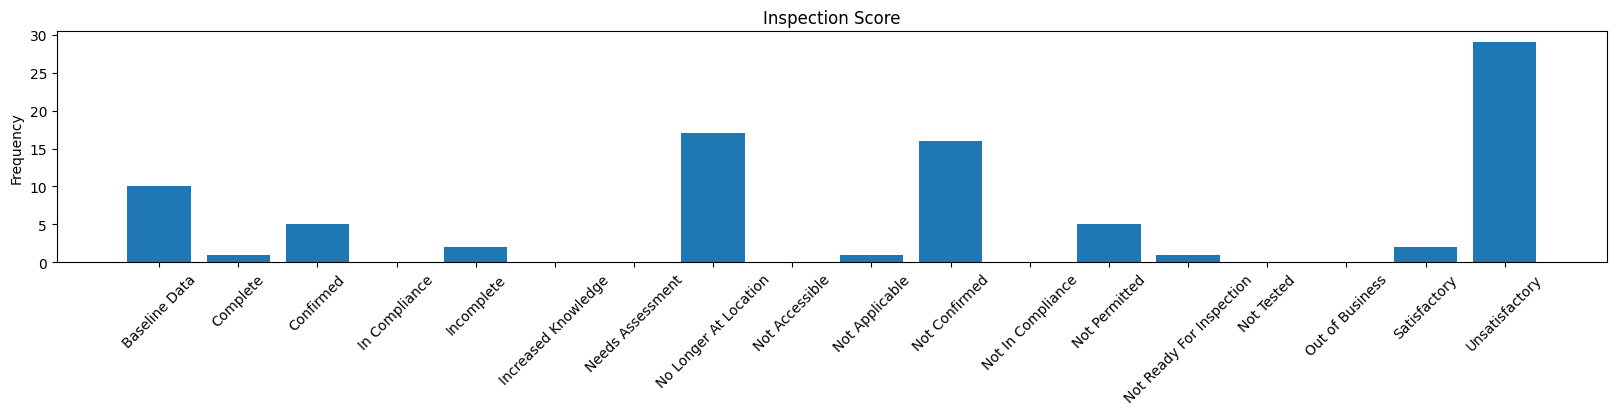

In [14]:
df_mean=np.round(df.groupby(['Inspection_Result']).agg({'Inspection_Score':'mean'}))
feature_data = df_mean.index
feature_count=df_mean['Inspection_Score']
plt.figure(figsize = (20,3))
plt.bar(feature_data,feature_count)
plt.xticks(feature_count.index, feature_count.index.values,rotation=45)
plt.ylabel("Frequency")
plt.title('Inspection Score')
plt.show()

In [15]:
df.loc[:,('Inspection_Score')] =np.round( df.groupby(['Inspection_Result'], group_keys=False)['Inspection_Score']
                     .apply(lambda x: x.fillna(x.mean())))

In [16]:
df.loc[:,('Violation_Type')] =df['Violation_Type'].fillna("Green")

In [17]:
df['Violation_Description'] = df['Violation_Description'].fillna("No_violation")

In [18]:
df.loc[:,('Grade')] =np.round( df.groupby(['Inspection_Score'], group_keys=False)['Grade']
                     .apply(lambda x: x.fillna(x.mean())))

In [19]:
df.isna().sum()

Name                          0
Inspection_Date               0
Description                   0
City                          0
Longitude                     0
Latitude                      0
Inspection_Type               0
Inspection_Score              0
Inspection_Result             0
Inspection_Closed_Business    0
Violation_Type                0
Violation_Description         0
Violation_Points              0
Business_ID                   0
Grade                         0
dtype: int64

# Remove Outliers

<AxesSubplot: >

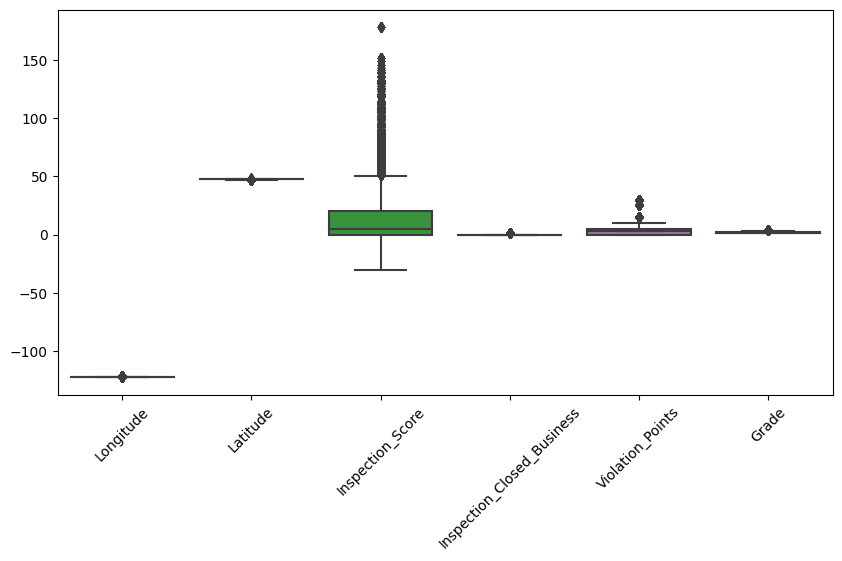

In [20]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
sns.boxplot(data=df)

In [21]:
df.describe()

,Longitude,Latitude,Inspection_Score,Violation_Points,Grade
count,249804.000000,249804.000000,249804.000000,249804.000000,249804.000000
mean,-122.256275,47.563756,14.147752,4.424861,1.311688
std,0.113753,0.128777,20.287694,6.165551,0.539006
min,-122.518749,47.155934,-30.000000,0.000000,1.000000
25%,-122.333593,47.478803,0.000000,0.000000,1.000000
50%,-122.299547,47.604297,5.000000,3.000000,1.000000
75%,-122.197881,47.661558,20.000000,5.000000,2.000000
max,-121.090900,48.415296,178.000000,30.000000,4.000000


In [4]:
cols = ["Longitude","Latitude","Inspection_Score","Violation_Points"]
Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
new_data =df[ ~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
new_data.describe()


In [23]:
df['Inspection_Date'] = pd.to_datetime(df['Inspection_Date'])
df.head()

,Name,Inspection_Date,Description,City,Longitude,Latitude,Inspection_Type,Inspection_Score,Inspection_Result,Inspection_Closed_Business,Violation_Type,Violation_Description,Violation_Points,Business_ID,Grade
0,#807 TUTTA BELLA,2022-08-31,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,False,BLUE,"3200 - Insects, rodents, animals not present; ...",5,PR0089260,1.0
1,#807 TUTTA BELLA,2022-08-31,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,False,RED,0200 - Food Worker Cards current for all food ...,5,PR0089260,1.0
2,#807 TUTTA BELLA,2022-01-13,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,0.0,Satisfactory,False,Green,No_violation,0,PR0089260,1.0
3,#807 TUTTA BELLA,2021-01-06,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,0.0,Satisfactory,False,Green,No_violation,0,PR0089260,1.0
4,+MAS CAFE,2022-07-13,Seating 0-12 - Risk Category III,seattle,-122.334587,47.648180,Return Inspection,0.0,Satisfactory,False,Green,No_violation,0,PR0046367,2.0


# Add Year	Month	day_of_week	Season columns according to Inspection_Date

In [137]:
df['Year'] = pd.DatetimeIndex(df['Inspection_Date']).year
df['Month'] = pd.DatetimeIndex(df['Inspection_Date']).month
df['day_of_week'] = df['Inspection_Date'].dt.day_name()
df.head()

,Name,Inspection_Date,Description,City,Longitude,Latitude,Inspection_Type,Inspection_Score,Inspection_Result,Inspection_Closed_Business,Violation_Type,Violation_Description,Violation_Points,Business_ID,Grade,Year,Month,day_of_week,Season
0,#807 TUTTA BELLA,2022-08-31,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,False,BLUE,"3200 - Insects, rodents, animals not present; ...",5,PR0089260,1.0,2022,8,Wednesday,Summer
1,#807 TUTTA BELLA,2022-08-31,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,False,RED,0200 - Food Worker Cards current for all food ...,5,PR0089260,1.0,2022,8,Wednesday,Summer
2,#807 TUTTA BELLA,2022-01-13,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,0.0,Satisfactory,False,Green,No_violation,0,PR0089260,1.0,2022,1,Thursday,Winter
3,#807 TUTTA BELLA,2021-01-06,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,0.0,Satisfactory,False,Green,No_violation,0,PR0089260,1.0,2021,1,Wednesday,Winter
4,+MAS CAFE,2022-07-13,Seating 0-12 - Risk Category III,seattle,-122.334587,47.648180,Return Inspection,0.0,Satisfactory,False,Green,No_violation,0,PR0046367,2.0,2022,7,Wednesday,Summer


In [25]:
def find_season(month, hemisphere):
    if hemisphere == 'Southern':
        season_month_south = {
            12:'Summer', 1:'Summer', 2:'Summer',
            3:'Autumn', 4:'Autumn', 5:'Autumn',
            6:'Winter', 7:'Winter', 8:'Winter',
            9:'Spring', 10:'Spring', 11:'Spring'}
        return season_month_south.get(month)
        
    elif hemisphere == 'Northern':
        season_month_north = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}
        return season_month_north.get(month)
    else:
        print('Invalid selection. Please select a hemisphere and try again')

In [26]:
season_list = []
hemisphere = 'Northern'
for month in df['Month']:
    season = find_season(month, hemisphere)
    season_list.append(season)
    
df['Season'] = season_list
df.head()

,Name,Inspection_Date,Description,City,Longitude,Latitude,Inspection_Type,Inspection_Score,Inspection_Result,Inspection_Closed_Business,Violation_Type,Violation_Description,Violation_Points,Business_ID,Grade,Year,Month,day_of_week,Season
0,#807 TUTTA BELLA,2022-08-31,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,False,BLUE,"3200 - Insects, rodents, animals not present; ...",5,PR0089260,1.0,2022,8,Wednesday,Summer
1,#807 TUTTA BELLA,2022-08-31,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,False,RED,0200 - Food Worker Cards current for all food ...,5,PR0089260,1.0,2022,8,Wednesday,Summer
2,#807 TUTTA BELLA,2022-01-13,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,0.0,Satisfactory,False,Green,No_violation,0,PR0089260,1.0,2022,1,Thursday,Winter
3,#807 TUTTA BELLA,2021-01-06,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,0.0,Satisfactory,False,Green,No_violation,0,PR0089260,1.0,2021,1,Wednesday,Winter
4,+MAS CAFE,2022-07-13,Seating 0-12 - Risk Category III,seattle,-122.334587,47.648180,Return Inspection,0.0,Satisfactory,False,Green,No_violation,0,PR0046367,2.0,2022,7,Wednesday,Summer


In [27]:
data=df.to_csv('Clean_Data.csv')

# Corrolation plots:

In [28]:
df1=pd.read_csv('Clean_Data.csv')
df1 = df1.loc[:, ~df1.columns.str.contains('^Unnamed')]
df1.head()

,Name,Inspection_Date,Description,City,Longitude,Latitude,Inspection_Type,Inspection_Score,Inspection_Result,Inspection_Closed_Business,Violation_Type,Violation_Description,Violation_Points,Business_ID,Grade,Year,Month,day_of_week,Season
0,#807 TUTTA BELLA,2022-08-31,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,False,BLUE,"3200 - Insects, rodents, animals not present; ...",5,PR0089260,1.0,2022,8,Wednesday,Summer
1,#807 TUTTA BELLA,2022-08-31,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,False,RED,0200 - Food Worker Cards current for all food ...,5,PR0089260,1.0,2022,8,Wednesday,Summer
2,#807 TUTTA BELLA,2022-01-13,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,0.0,Satisfactory,False,Green,No_violation,0,PR0089260,1.0,2022,1,Thursday,Winter
3,#807 TUTTA BELLA,2021-01-06,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,0.0,Satisfactory,False,Green,No_violation,0,PR0089260,1.0,2021,1,Wednesday,Winter
4,+MAS CAFE,2022-07-13,Seating 0-12 - Risk Category III,seattle,-122.334587,47.648180,Return Inspection,0.0,Satisfactory,False,Green,No_violation,0,PR0046367,2.0,2022,7,Wednesday,Summer


In [3]:
data1 = pd.read_csv('new.csv',sep=',')
data1

,Unnamed: 0,Name,Inspection_Date,Description,City,Longitude,Latitude,Inspection_Type,Inspection_Score,Inspection_Result,...,Business_ID,Grade,Year,Month,day_of_week,Season,Chain_res,IS_chain,Date_ins_year,violation_total
0,0,#807 TUTTA BELLA,2022-08-31,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,...,PR0089260,1.0,2022,8,Wednesday,Summer,1,False,4,2.0
1,1,#807 TUTTA BELLA,2022-08-31,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,10.0,Unsatisfactory,...,PR0089260,1.0,2022,8,Wednesday,Summer,1,False,4,2.0
2,2,#807 TUTTA BELLA,2022-01-13,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,0.0,Satisfactory,...,PR0089260,1.0,2022,1,Thursday,Winter,1,False,4,NaN
3,3,#807 TUTTA BELLA,2021-01-06,Seating 0-12 - Risk Category III,seattle,-122.296415,47.662311,Routine Inspection/Field Review,0.0,Satisfactory,...,PR0089260,1.0,2021,1,Wednesday,Winter,1,False,4,NaN
4,4,+MAS CAFE,2022-07-13,Seating 0-12 - Risk Category III,seattle,-122.334587,47.648180,Return Inspection,0.0,Satisfactory,...,PR0046367,2.0,2022,7,Wednesday,Summer,1,False,8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249799,249799,ZYLBERSCHTEIN'S DELICATESSEN & BAKERY,2018-11-21,Seating 0-12 - Risk Category III,seattle,-122.312056,47.715359,Consultation/Education - Field,0.0,Complete,...,PR0086991,2.0,2018,11,Wednesday,Autumn,1,False,11,NaN
249800,249800,ZYLBERSCHTEIN'S DELICATESSEN & BAKERY,2018-05-09,Seating 0-12 - Risk Category III,seattle,-122.312056,47.715359,Routine Inspection/Field Review,0.0,Satisfactory,...,PR0086991,2.0,2018,5,Wednesday,Spring,1,False,11,NaN
249801,249801,ZYLBERSCHTEIN'S DELICATESSEN & BAKERY,2017-11-27,Seating 0-12 - Risk Category III,seattle,-122.312056,47.715359,Routine Inspection/Field Review,0.0,Satisfactory,...,PR0086991,2.0,2017,11,Monday,Autumn,1,False,11,NaN
249802,249802,ZYLBERSCHTEIN'S DELICATESSEN & BAKERY,2017-09-06,Seating 0-12 - Risk Category III,seattle,-122.312056,47.715359,Consultation/Education - Field,0.0,Complete,...,PR0086991,2.0,2017,9,Wednesday,Autumn,1,False,11,NaN




<div style="direction:rtl;line-height:300%;">
	همانطور که در نمودار زیر مشخص است, ستون های:<br> 
 Violation point و Inspection score<br>
    Grade , Inspection score<br>
    Grade , Violation points <br>
    به ترتیب بیشترین همبستگی را با هم دارند.
</div>

/var/folders/t4/bptgh3hx6bz480z9tyq5f9780000gn/T/ipykernel_90201/3869776604.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df1.corr(), cmap = "YlGnBu", annot = True)


<AxesSubplot: >

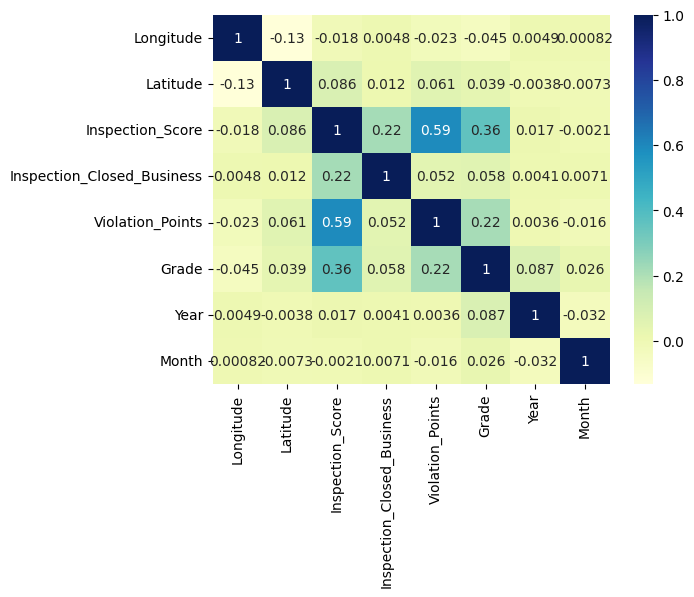

In [30]:
sns.heatmap(df1.corr(), cmap = "YlGnBu", annot = True)

<AxesSubplot: xlabel='Inspection_Result', ylabel='Violation_Type'>

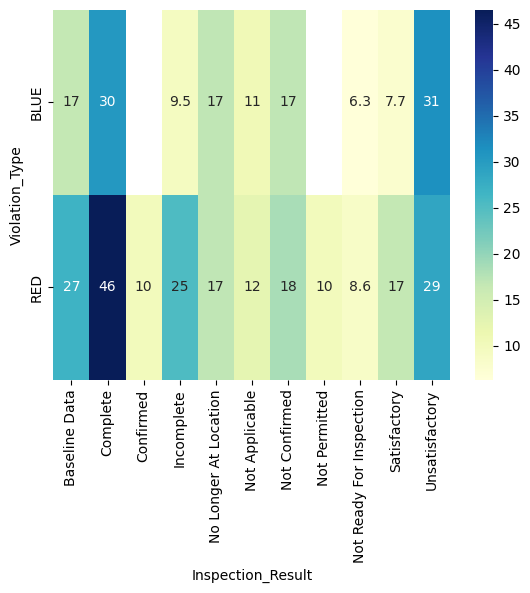

In [31]:
df_new = df1[df1.Violation_Type != "Green"]
df_heatmap = df_new.pivot_table(values = 'Inspection_Score', index = 'Violation_Type', columns = 'Inspection_Result', aggfunc = np.mean)
sns.heatmap(df_heatmap, cmap = 'YlGnBu', annot = True)

# مرحله اول
در ابتدا به بررسی جامعه اماری پرداخته ایم که این دیتاست شامل چه تعداد شهر میباشد و هر شهر دارای چه تعداد رستوران میباشد و هر رستوران دارای چند شعبه ی زنجیره ای میباشد و همچنین هر شهر دارای چه تعداد رستوران درجه یک و .. میباشد و ایا این که این رستوران های زنجیره ای بیشتر دارای کدام درجه میباشند و در مرحله بعد به بررسی تعداد بازدید ها و بررسی علت و امتیاز تخلفات پرداخته ایم و این که ایا تخلفات منجر به بسته شدن رستوران ها گردیده است یا خیر و ایا تعطیلی رستوران ها به علت بحران جهانی بوده است   

In [50]:
df1["City"] =df1["City"].apply(lambda x: x.lower())

در این دیتا ست بهداشت 53 شهر مورد بررسی قرار گرفته است

In [33]:
Count_num=df1['City'].nunique()
print(f'number of city: {Count_num}')

number of city: 53


شهرهای مورد بررسی قرار گرفته شده در نقشه زیر نمایش داده شده است

Text(0.5, 1.0, 'Cities')

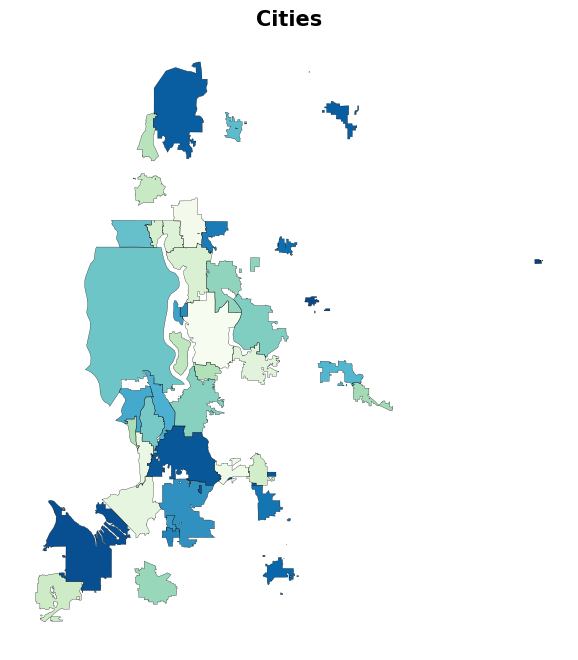

In [41]:
df_City = df[['City']].copy()
df_City = df_City.groupby('City').mean()
shape_City = pd.merge(left=shape, right=df_City, left_on="NAME", right_on="City", how = 'inner')
shape_Grade = gpd.GeoDataFrame(shape_City)
ax = shape_Grade.boundary.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_Grade.plot(ax = ax,legend = True, cmap = "GnBu", legend_kwds={'shrink': 0.3})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Cities', size = 15, weight = 'bold')


حدود 48 در صد اطلاعات مربوط به دیتاست مربوط به شهر سیاتل است
به عبارتی 48 درصد رستوران ها در شهر سیاتل واقع شده اند چون شهر سیاتل یکی از بزرگترین شهر ها در دیتاست میباشد

In [147]:
#درصد فراوانی هر شهر
Count_num=np.round(df1['City'].value_counts(normalize=True)*100)
Count_num.to_frame().head()
Count_num =pd.DataFrame({'City':Count_num.index, 'Number':Count_num.values})
Count_num.head(5)

,City,Number
0,seattle,48.0
1,bellevue,7.0
2,kent,5.0
3,federal way,5.0
4,renton,5.0


و حدود 4346 رستوران در شهر سیاتل واقع شده است

In [146]:
#پیدا کردن تعداد رستوران های  هر شهر
count =df1.groupby(['City'])['Name'].nunique().sort_values(ascending=False)
count.to_frame().head()


,Name
City,
seattle,4349
bellevue,647
kent,524
renton,478
redmond,398


نمایش فراوانی رستوران ها نمودار زیر

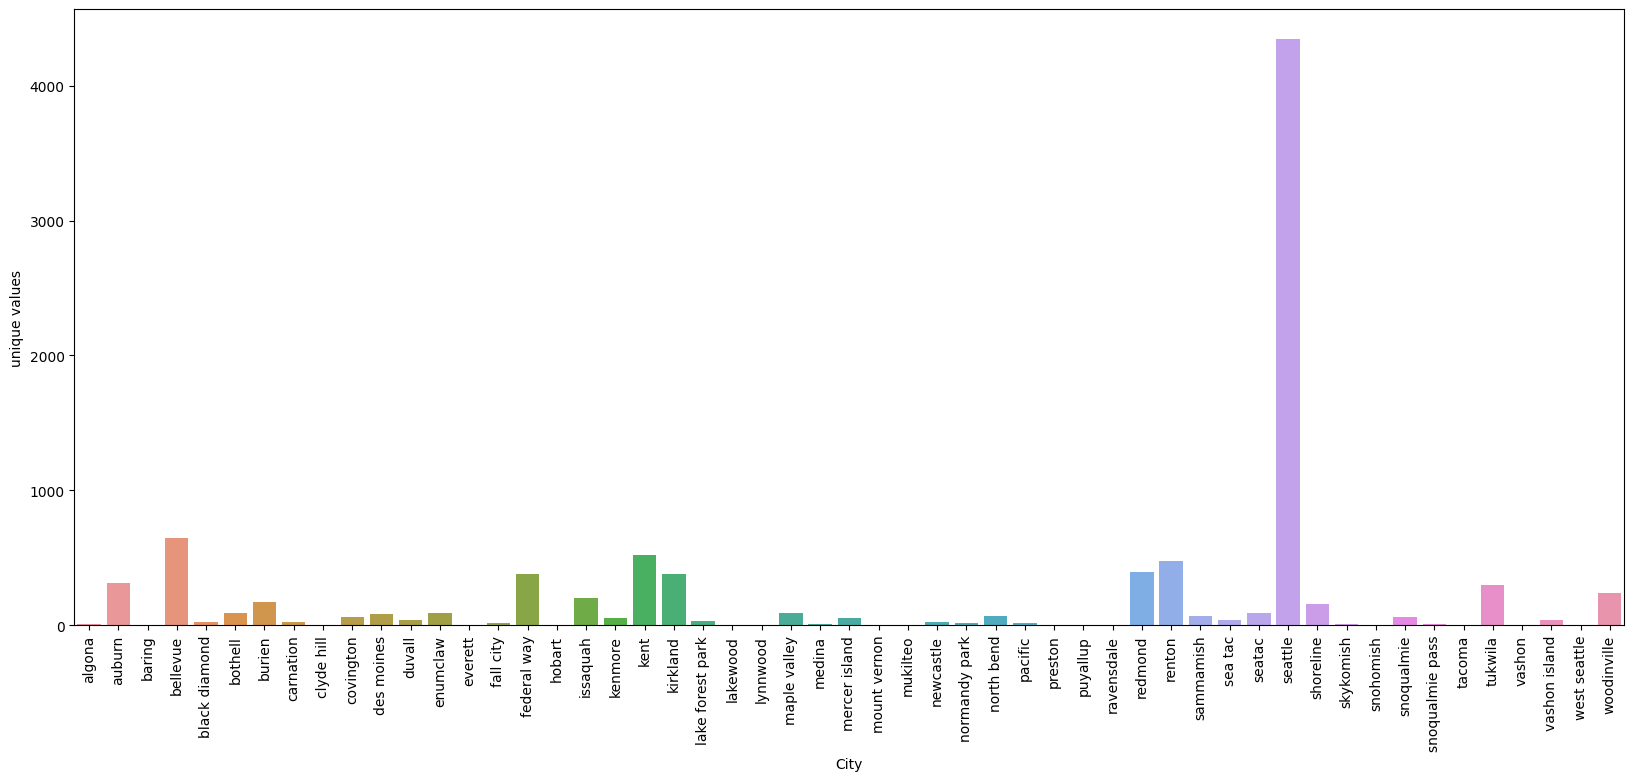

In [138]:
df5= (df1.groupby('City', sort=True)
         .agg(**{'unique values': ('Name', 'nunique')})
         .reset_index()
      )
plt.figure(figsize = (20,8))
sns.barplot(data=df5, x='City', y='unique values')
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Cities')

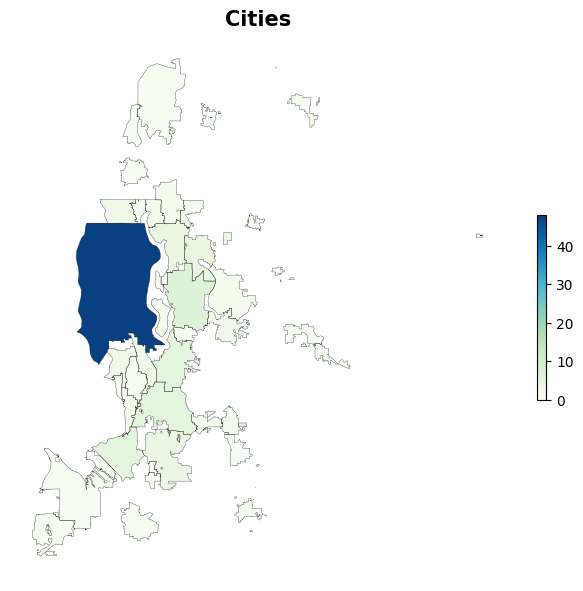

In [148]:
shape_City = pd.merge(left=shape, right=Count_num, left_on="NAME", right_on="City", how = 'inner')
shape_City = gpd.GeoDataFrame(shape_City)
ax = shape_City.boundary.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_City.plot(ax = ax,column ='Number',legend = True, cmap = "GnBu", legend_kwds={'shrink': 0.3})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Cities', size = 15, weight = 'bold')

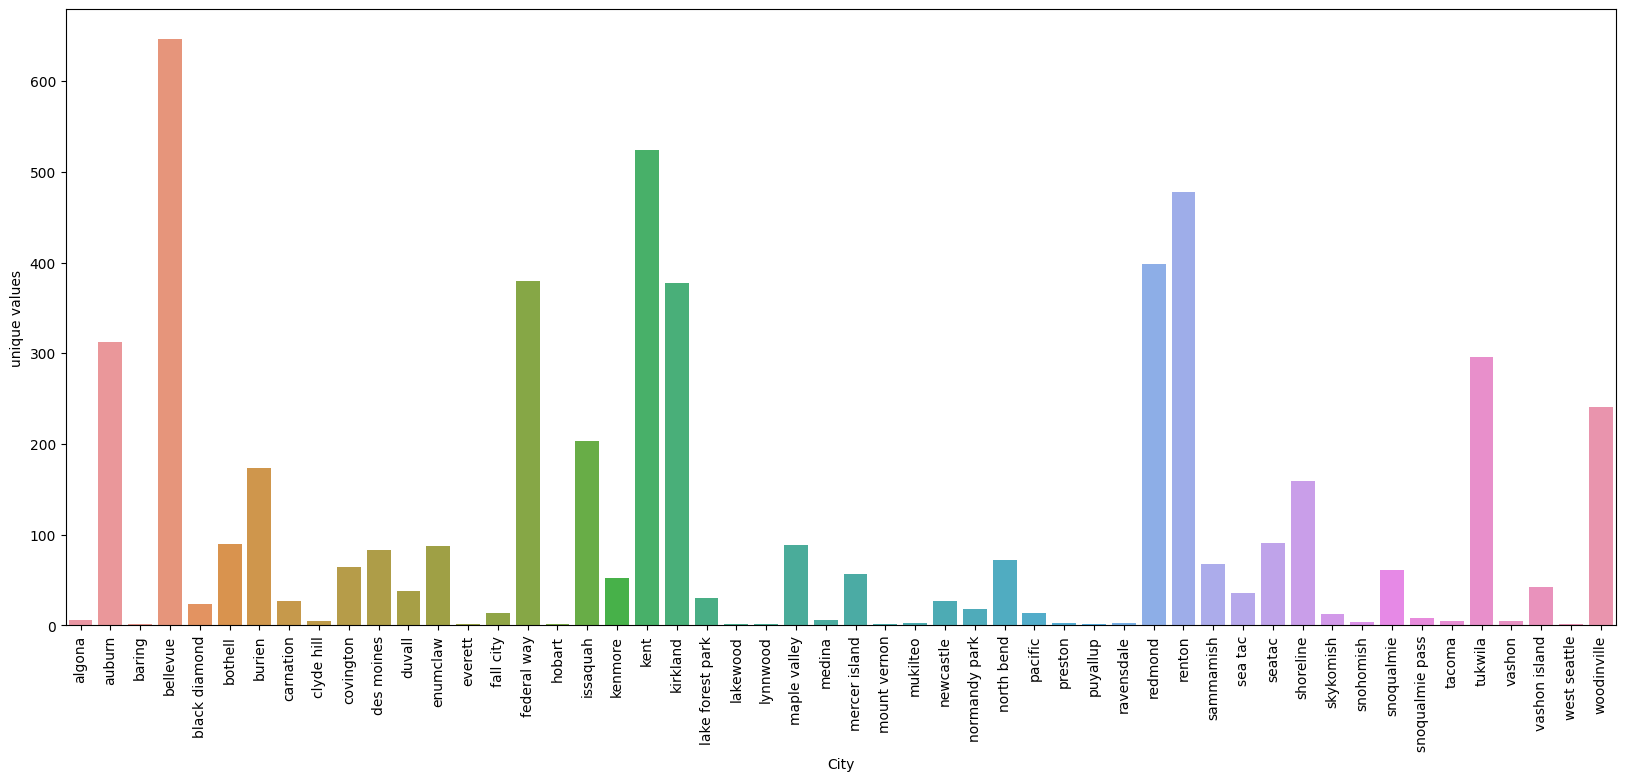

In [143]:
df5= (df1.groupby('City', sort=True)
         .agg(**{'unique values': ('Name', 'nunique')})
         .reset_index()
      )
df5.drop([41], axis=0,inplace=True)
plt.figure(figsize = (20,8))
sns.barplot(data=df5, x='City', y='unique values')
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Cities without Seattle')

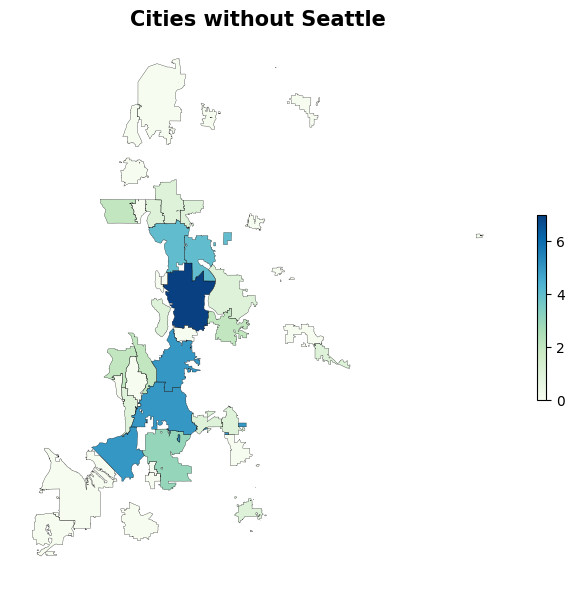

In [153]:
shape_City = pd.merge(left=shape, right=Count_num, left_on="NAME", right_on="City", how = 'inner')
shape_City.drop([22], axis=0,inplace=True)
shape_City = gpd.GeoDataFrame(shape_City)
ax = shape_City.boundary.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_City.plot(ax = ax,column ='Number',legend = True, cmap = "GnBu", legend_kwds={'shrink': 0.3})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Cities without Seattle', size = 15, weight = 'bold')

در اینجا رستورانهای زنجیره ای در سطح شهرهای مختلف را پیدا کردیم و همانطور که واضح است شهر سیاتل دارای بیشترین رستوران های زنجیره ای میباشد که بیش از 80 درصد این شعبات درجه یک هستند 
و نمودار 15 تا از رستورانهای زنجیره ای برتر را نمایش داده ایم


حدود 24 درصد رستوران ها زنجیره ای هستند

In [56]:
Count_num=np.round(df1['IS_chain'].value_counts(normalize=True)*100)

In [70]:
count =df1.groupby(['Name','City'])['Business_ID'].nunique().sort_values(ascending=False)
count.to_frame()


,,Business_ID
Name,City,
LEVY RESTAURANTS @ LUMEN FIELD,seattle,87
T-MOBILE PARK,seattle,76
ARENA AT SEATTLE CENTER,seattle,59
FACEBOOK INC,seattle,31
PCC COMMUNITY MARKETS,seattle,28
...,...,...
GIDDY UP BURGERS AND MORE,seattle,1
GILBERT'S GREATS LLC,seattle,1
GILBERTS MAIN STREET BAGEL DELI,bellevue,1


In [71]:
count =df1.groupby(['Name','Grade'])['Business_ID'].nunique().sort_values(ascending=False)
count.to_frame()


,,Business_ID
Name,Grade,
LEVY RESTAURANTS @ LUMEN FIELD,1.0,73
T-MOBILE PARK,1.0,63
ARENA AT SEATTLE CENTER,1.0,58
FACEBOOK INC,1.0,47
PCC COMMUNITY MARKETS,1.0,37
...,...,...
GOOGLE TROLL CAFE,1.0,1
GOOGLE WAT2 BARISTA,1.0,1
"GOOSE PUB AND EATERY INC, THE",1.0,1


<AxesSubplot: xlabel='Name,Grade'>

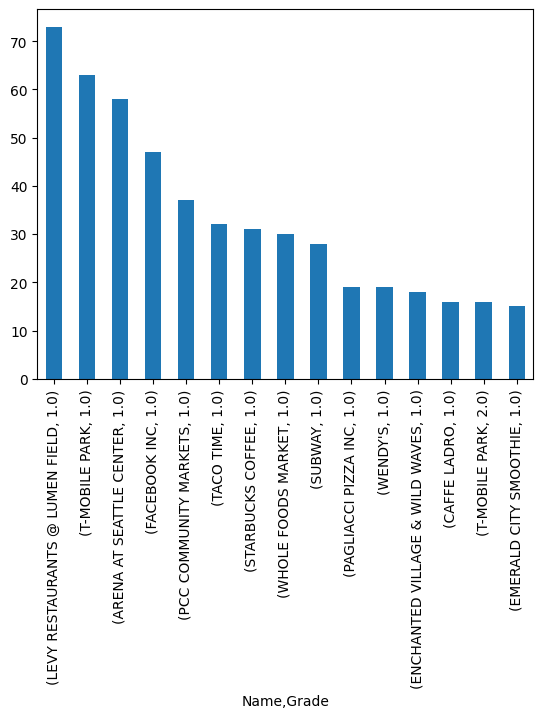

In [72]:
count.head(15).plot(kind='bar')

Text(0, 0.5, 'Show the grade of Chain restaurants')

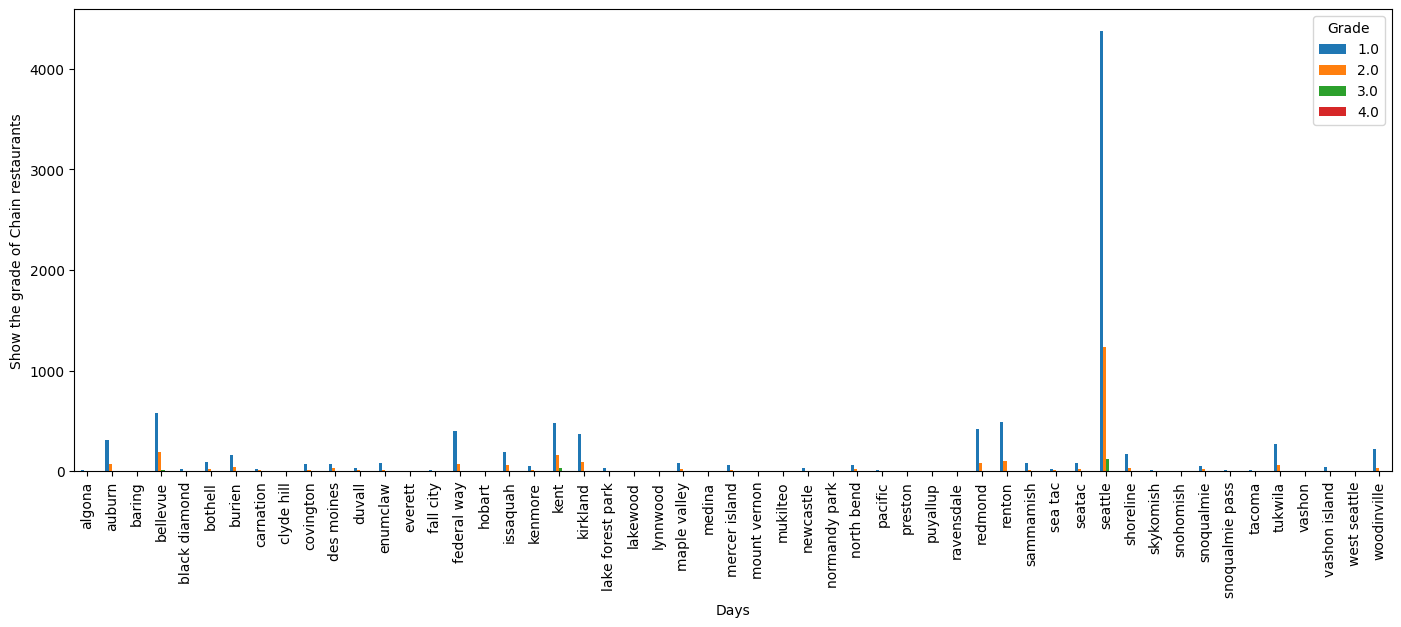

In [73]:
df_pivot = pd.pivot_table(
    data1,
    values='Business_ID',
    index="City", 
    columns='Grade',
    aggfunc='nunique'
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Days")
ax.set_ylabel("Show the grade of Chain restaurants")

Text(0, 0.5, 'Show the grade of Chain restaurants')

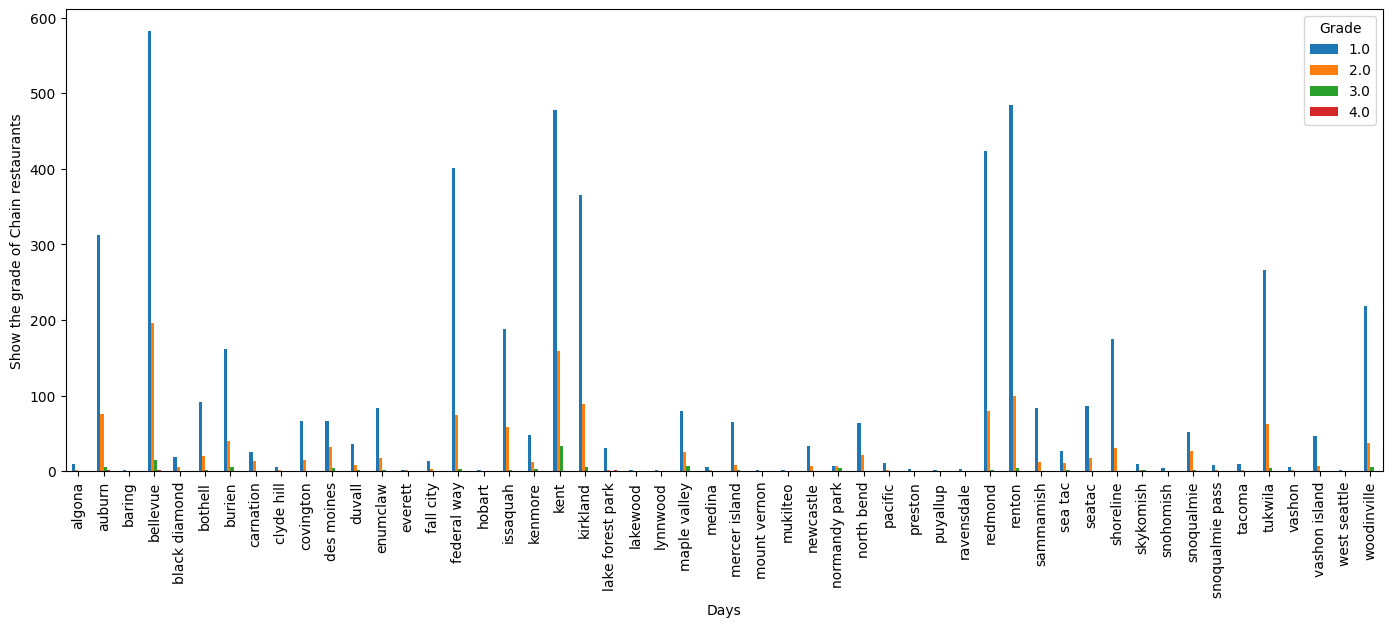

In [112]:
df_pivot = pd.pivot_table(
    data1,
    values='Business_ID',
    index="City", 
    columns='Grade',
    aggfunc='nunique'
)
df_pivot.drop(['seattle'],axis=0,inplace=True)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Days")
ax.set_ylabel("Show the grade of Chain restaurants")

#  نمایش در نقشه بررسی اینکه کدام شهرها دارای بیشترین رستورانهای زنجیره ای هستند بر مبنای data1

Text(0.5, 1.0, 'Cities')

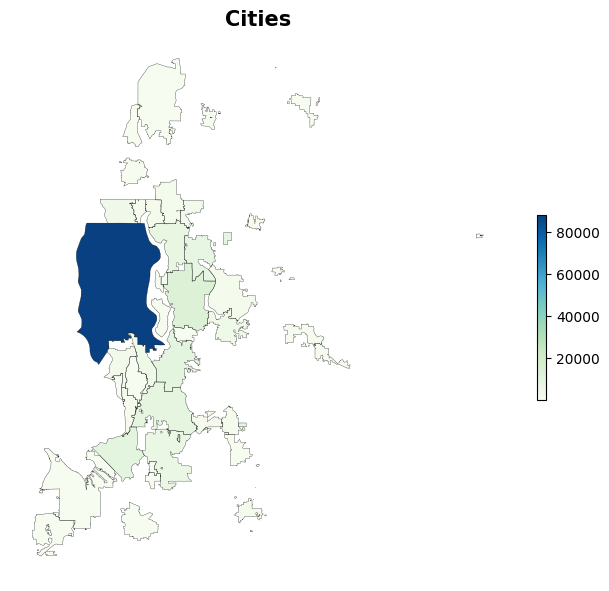

In [99]:
df_chain = df1[['Name', 'City', 'IS_chain']].copy()
df_chain = df_chain.groupby(['City',"IS_chain"]).size().groupby("City").max()
df_chain = pd.DataFrame({'City':df_chain.index, 'IS_chain':df_chain.values})
shape_chain = pd.merge(left=shape, right=df_chain, left_on="NAME", right_on="City", how = 'inner')
shape_chain = gpd.GeoDataFrame(shape_chain)
ax = shape_chain.boundary.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_chain.plot(ax = ax,column='IS_chain' ,legend = True, cmap = "GnBu", legend_kwds={'shrink': 0.3})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Cities', size = 15, weight = 'bold')

با حذف سیاتل از داده‌ها:

Text(0.5, 1.0, 'Cities without Seattle')

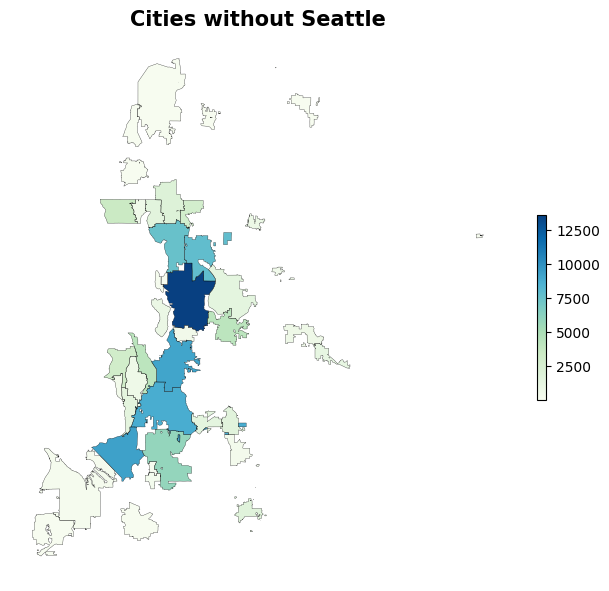

In [109]:
df_chain = df1[['Name', 'City', 'IS_chain']].copy()
df_chain = df_chain.groupby(['City',"IS_chain"]).size().groupby("City").max()
df_chain = pd.DataFrame({'City':df_chain.index, 'IS_chain':df_chain.values})
shape_chain = pd.merge(left=shape, right=df_chain, left_on="NAME", right_on="City", how = 'inner')
shape_chain.drop([22],axis=0,inplace=True)
shape_chain = gpd.GeoDataFrame(shape_chain)
ax = shape_chain.boundary.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_chain.plot(ax = ax,column='IS_chain' ,legend = True, cmap = "GnBu", legend_kwds={'shrink': 0.3})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Cities without Seattle', size = 15, weight = 'bold')

همانطور که از نمودار زیر مشخص است تعداد رستوران های زنجیره ای در سال 2020 به شدت کاهش پیدا کرده است و در زیر به بررسی علت این کاهش میپردازیم

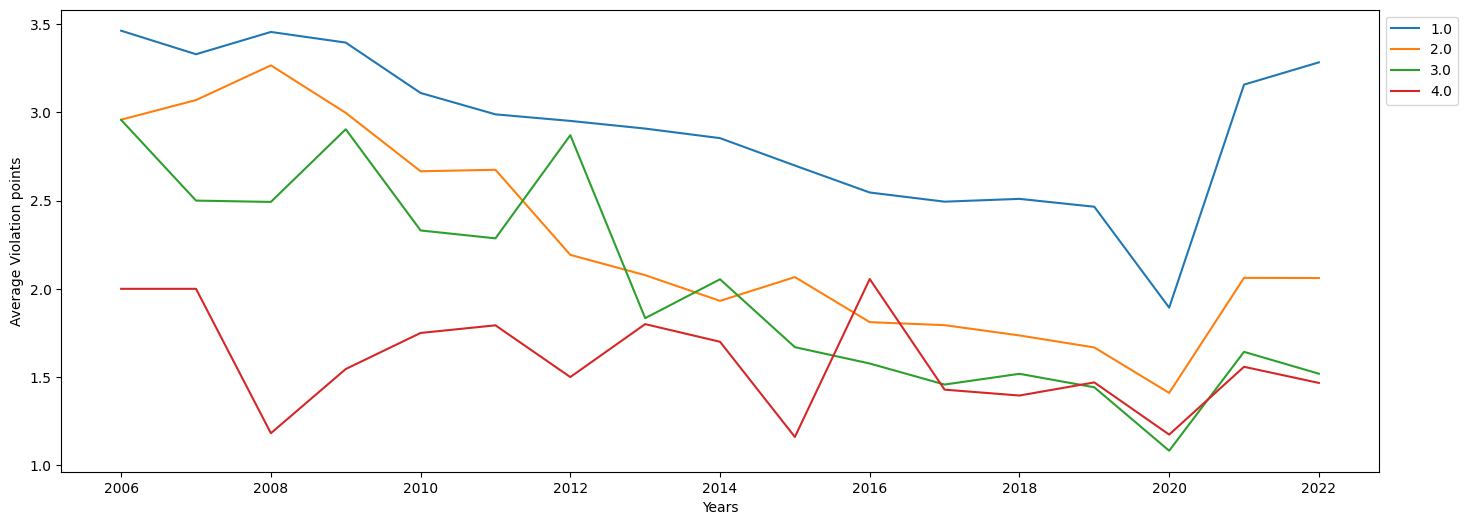

In [154]:
df_pivot = pd.pivot_table(
    data1,
    values="Chain_res",
    index="Year",
    columns="Grade",
    aggfunc='mean'
)
ax = df_pivot.plot(kind="line")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points")
ax.legend(bbox_to_anchor=(1.0, 1.0))

و همانطور که از نمودار زیر مشخص است تعداد رستوران ها در سال 2020 به شدت کاهش پیدا کرده است و در مراحل زیر میخواهیم بررسی کنیم ایا این تعطیلی ها ناشی از موارد تخلفات است یا ناشی از بحران جهانی کرونا

<AxesSubplot: xlabel='Year'>

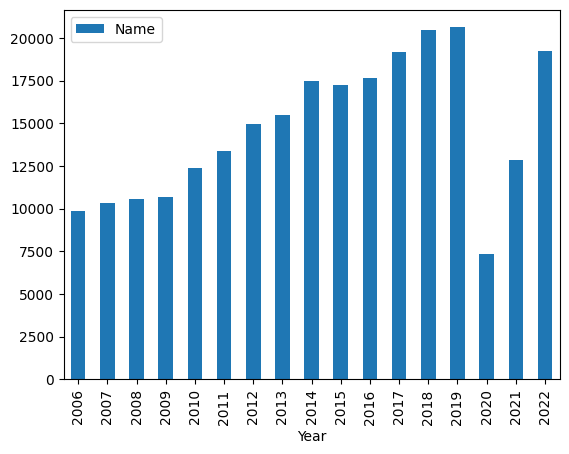

In [155]:
count =df.groupby('Year')['Name'].count()
count.to_frame().plot(kind='bar')

****************************************************************************************************************11111

در این مرحله به بررسی تعداد بازرسی ها و تعداد تخلفات و بررسی رابطه امتیاز ها و نوع تخلفات و بسته یا باز بودن رستوران پرداخته ایم


In [156]:
df1['Chain_res'] =df1.groupby(['Name','City'], sort=False)['Business_ID'].transform('nunique')
df1.loc[:,'IS_chain'] = df1['Chain_res'] >1

df1.loc[:,('Date_ins_year')] = df1.groupby(['Business_ID','Grade'], sort=False)['Violation_Type'].transform('count')
df1.loc[:,'violation_total'] = df1[(df1['Violation_Type'] == 'BLUE')| (df1['Violation_Type'] == 'RED')].groupby(['Name','Grade'], sort=True)['Violation_Type'].transform('count')

In [157]:
df1.to_csv('new.csv')

In [158]:
data1 = pd.read_csv('new.csv',sep=',')


جدول زیر نمایشگر تعداد بازدید های صورت گرفته و تعداد تخلفات که منجر به دریافت کارت شده است از هر رستوران بر اساس رستوران های زنجیره ای و سال ها میباشد. 

همانطور که مشخص است رستوران های درجه 2 شهر سیاتل بیشترین تعداد بازرسی ها و بیشترین تعداد کارت هارا دارند حال میخواهیم بررسی کنیم علت تخلفات و تعداد کارت ها چه بوده است و چه تعداد رستوران بسته شده است 

In [159]:
pivot =np.round(pd.pivot_table(data1, values=('Chain_res','Date_ins_year','violation_total','Year','IS_chain'), 
                        index=['Name','City']).sort_values(by=['Date_ins_year'], ascending=False).fillna(0))
pivot

,,Chain_res,Date_ins_year,IS_chain,Year,violation_total
Name,City,,,,,
JADE GARDEN LLC,seattle,1,240.0,0.0,2013.0,216.0
SAIGON DELI,seattle,2,238.0,1.0,2011.0,207.0
HARBOR CITY RESTAURANT,seattle,1,228.0,0.0,2015.0,206.0
TAN DINH DELI,seattle,1,205.0,0.0,2011.0,183.0
SAIGON VIETNAM DELI,seattle,1,185.0,0.0,2012.0,162.0
...,...,...,...,...,...,...
PETER PAN SEAFOOD CO LLC,seattle,1,1.0,0.0,2021.0,0.0
The Naked Grocer,seattle,1,1.0,0.0,2022.0,0.0
PETIT PEIRRE BAKERY,seattle,1,1.0,0.0,2022.0,1.0


و همچنین بررسی میکنیم ایا بازه ی زمانی روی تعداد تخلفات تاثیر داشته است یا خیر؟

همانطور که واضح تعداد بازدیدها و تعداد تخلفات در سالهای 2020 و 2021 و2022 تقریبا نصف سالهای 2006 تا 2015 میباشد و دلیل این موضوع کاهش به شدت زیاد تعداد رستوران ها در سال 2020 میباشد   

Text(0, 0.5, 'Sum of Inspection and violation')

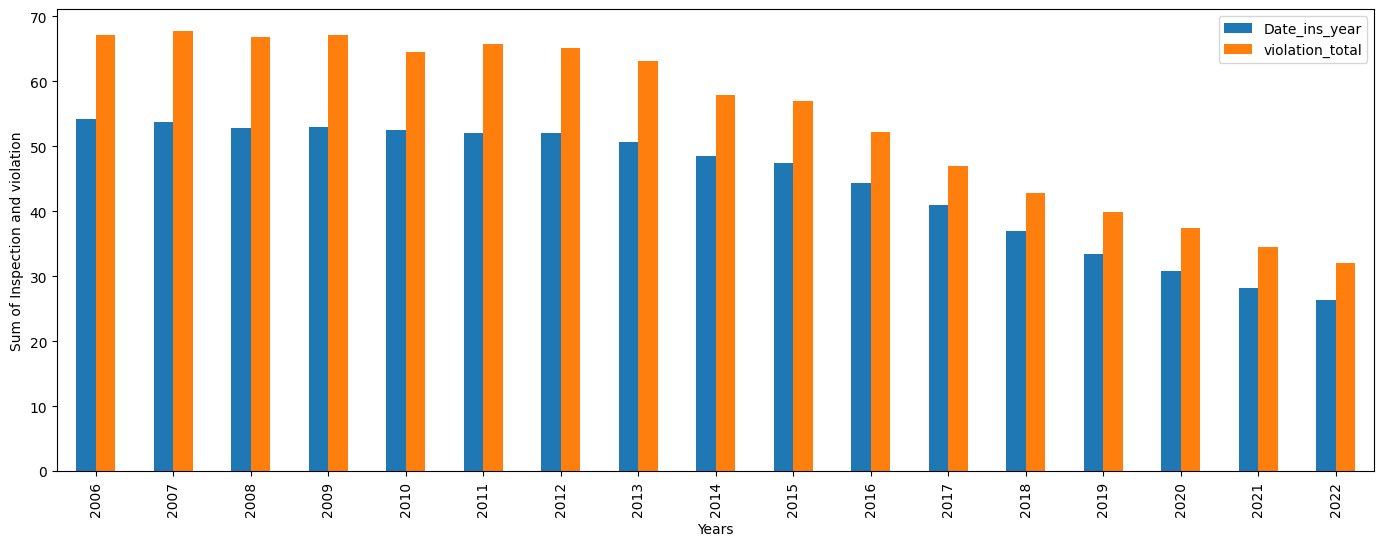

In [160]:
df_pivot = pd.pivot_table(
    data1,
    values=("Date_ins_year",'violation_total'),
    index="Year",    
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Sum of Inspection and violation")

در این قسمت به بررسی درجه رستوران ها میپردازیم همانطور که مشخص است رستورانهای درجه 4 بیشترین میزان تخلفات را داشته و به طبع آن میزان بازرسی های بیشتری را به خودش اختصاص داده است.

Text(0, 0.5, 'Sum of Inspection and violation')

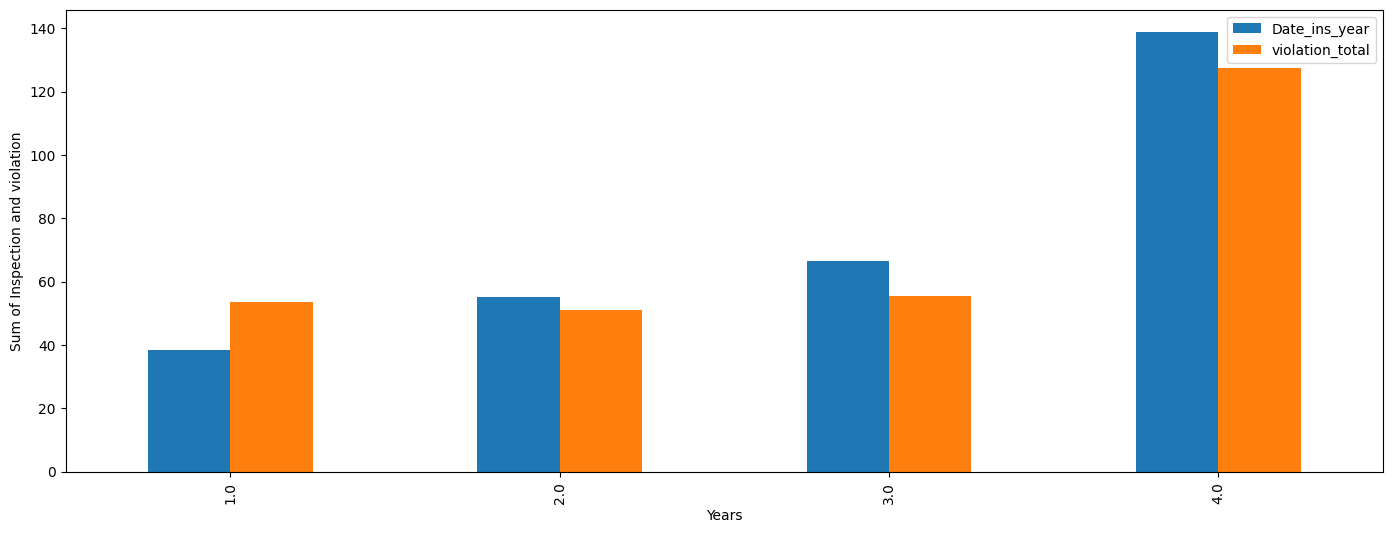

In [161]:
df_pivot = pd.pivot_table(
    data1,
    values=("Date_ins_year",'violation_total'),
    index="Grade",    
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Sum of Inspection and violation")

In [162]:
pivot = np.round(pd.pivot_table(data1, values=('Date_ins_year','violation_total','Year','Month','Season','day_of_week'), 
                        index=['City','Grade']).sort_values(by=['Date_ins_year'], ascending=False).fillna(0))
pivot

/var/folders/t4/bptgh3hx6bz480z9tyq5f9780000gn/T/ipykernel_90201/1574750161.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pivot = np.round(pd.pivot_table(data1, values=('Date_ins_year','violation_total','Year','Month','Season','day_of_week'),


,,Date_ins_year,Month,Year,violation_total
City,Grade,,,,
seattle,4.0,146.0,7.0,2016.0,132.0
duvall,3.0,118.0,9.0,2016.0,109.0
kenmore,3.0,115.0,7.0,2018.0,110.0
des moines,3.0,105.0,8.0,2013.0,91.0
sea tac,3.0,87.0,6.0,2013.0,71.0
...,...,...,...,...,...
everett,2.0,2.0,4.0,2006.0,2.0
west seattle,1.0,2.0,6.0,2022.0,0.0
medina,2.0,2.0,9.0,2019.0,2.0


در نمودار زیر به بررسی تعداد تخلفات در روزهای هفته پرداخته ایم و همانطور که واضح است روز یکشنبه که اخر هفته است و رستورانها شلوغ تر هستند موارد تخلف بیشتری رخ داده است اما به علت تعطیلات اخر هفته تعداد بازرسی های بیشتری صورت نگرفته است

Text(0, 0.5, 'Sum of Inspection and violation')

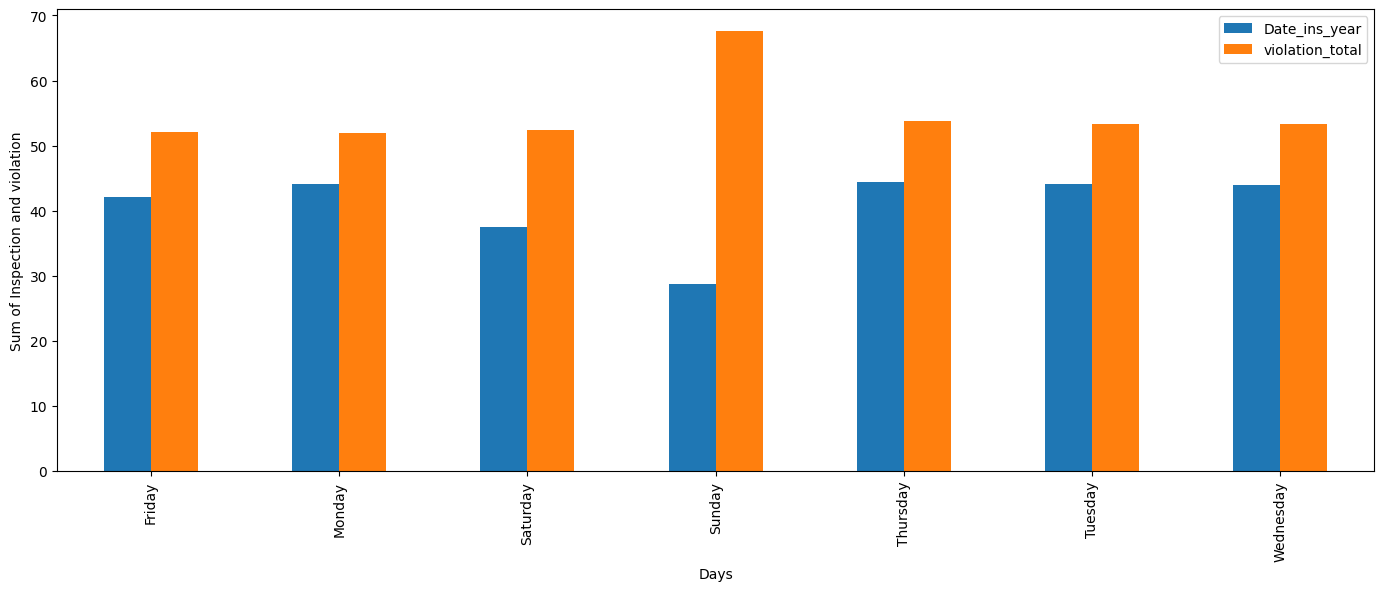

In [163]:
df_pivot = pd.pivot_table(
    data1,
    values=("Date_ins_year",'violation_total'),
    index="day_of_week",    
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Days")
ax.set_ylabel("Sum of Inspection and violation")


همانطور که از نمودار زیر مشخص است بیشترین کارت های تخلف مربوط به رستورانهای زنجیره ایی در اخر هفته ها میباشد اما تعداد بازدید ها در اخر هفته ها کاهش پیدا کرده است 

Text(0, 0.5, 'Sum of Inspection and violation')

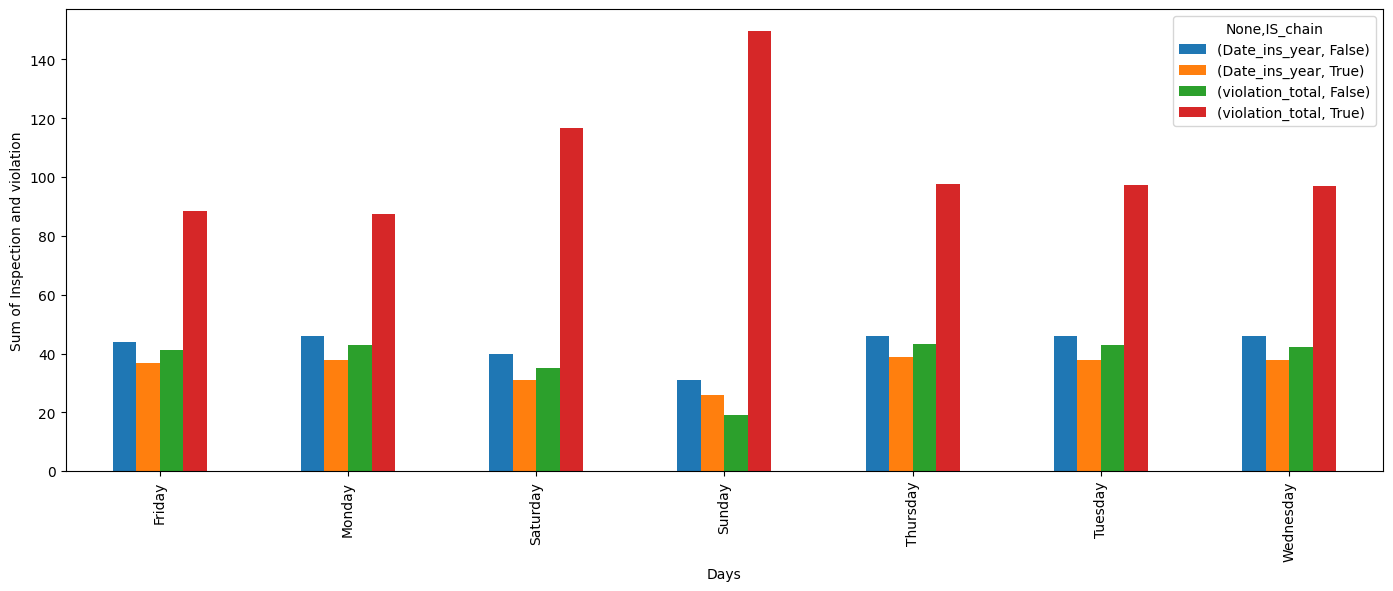

In [164]:
df_pivot = pd.pivot_table(
    data1,
    values=("Date_ins_year",'violation_total'),
    columns='IS_chain',
    index="day_of_week",    
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Days")
ax.set_ylabel("Sum of Inspection and violation")

در جدول زیر بررسی شده است کدام رستوران در کدام شهر بیشترین میانگین امتیاز بازرسی ها را دارد

همانطور که واضح است بیشترین ماینگین امتیازات بازرس مربوط به رستوران های درجه سه میباشد 

In [165]:
#محاسبه میانگین امتیاز های بازرسی و میانگین امتیاز های تخلفات
df_mean1=np.round(data1.groupby(['City','Name','IS_chain']).agg({'Inspection_Score':'mean'})).sort_values(by=['Inspection_Score'], ascending=False)
df_mean=df_mean1.groupby(level=1).head(1)
df_mean.head(15)

Inspection_Score
City    Name                           IS_chain                  
seattle BOCA PIZZERIA                  False                 92.0
kent    CAT SANG VIETNAMESE RESTAURANT False                 91.0
auburn  TOP PHO                        False                 88.0
kent    SPICE BLISS                    False                 88.0
        XO POT & BOWL                  False                 83.0
seattle CRAWFISH HOUSE                 False                 81.0
        BURBS BURGER- GEORGETOWN       False                 80.0
        BALLARD PHO & TERIYAKI         False                 73.0
        DELI SHEZ CAFE                 False                 73.0
kenmore FORTUNE INN                    False                 72.0
seattle BOMBAY GRILL                   False                 72.0
renton  KING BUFFET                    False                 69.0
seattle FREMONT BOWL                   False                 69.0
        YIFANG TAIWAN FRUIT TEA        False                 69.0
kent    FORTUNE SEAFOOD RESTAURANT     False                 66.0

نمودار میانگین امتیاز بازرسی ها بر اساس شهر و درجه رستوران ها 

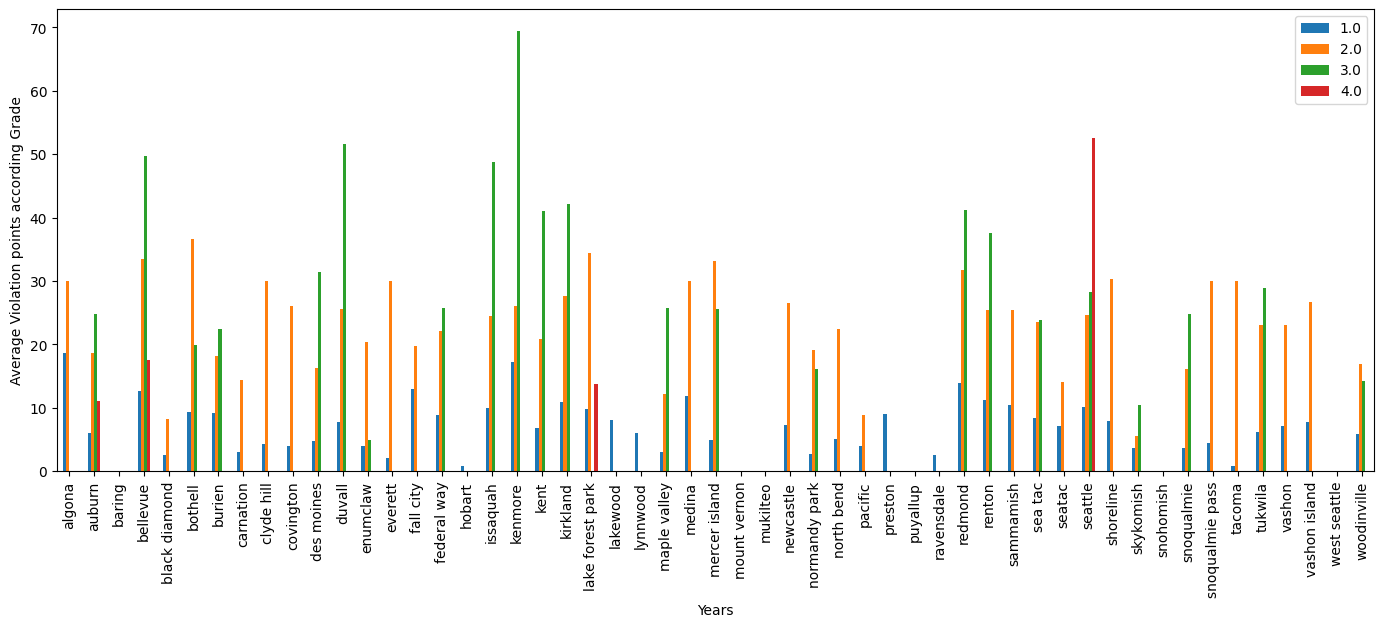

In [166]:
df_pivot = pd.pivot_table(
    df1,
    values="Inspection_Score",
    index="City",
    columns='Grade',
    aggfunc='mean'
    
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points according Grade")
ax.legend(bbox_to_anchor=(1.0, 1.0))

In [167]:
df_pivot.head(5)

Grade,1.0,2.0,3.0,4.0
City,,,,
algona,18.690789,30.000000,NaN,NaN
auburn,6.058863,18.647245,24.808511,11.0
baring,0.000000,NaN,NaN,NaN
bellevue,12.667186,33.397818,49.639610,17.5
black diamond,2.562264,8.278689,NaN,NaN


Text(0.5, 1.0, 'Grade 1')

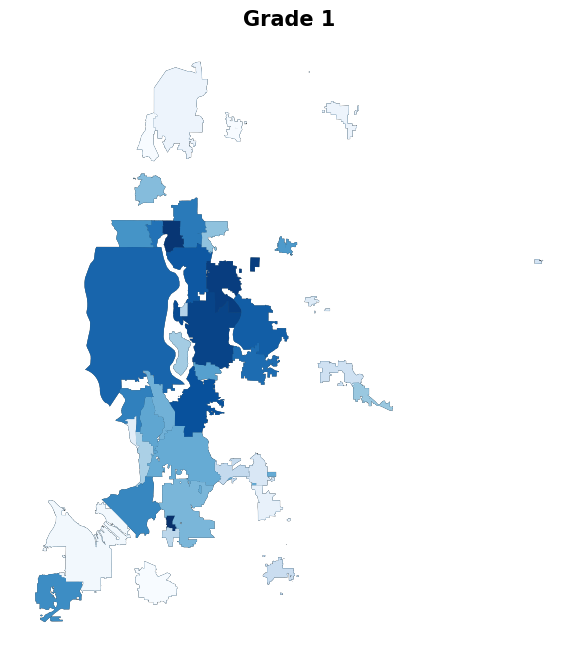

In [179]:
shape_grade = pd.merge(left=shape, right=df_pivot, left_on="NAME", right_on="City", how = 'inner')
shape_grade = gpd.GeoDataFrame(shape_grade)
ax = shape_grade.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_grade.plot(ax = ax , categorical=True,column=1.0, cmap = "Blues")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Grade 1', size = 15, weight = 'bold')

Text(0.5, 1.0, 'Grade 2')

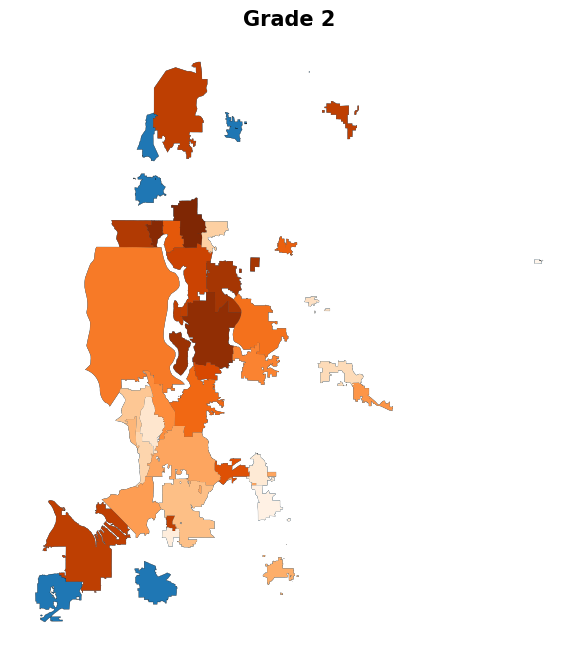

In [180]:
shape_grade = pd.merge(left=shape, right=df_pivot, left_on="NAME", right_on="City", how = 'inner')
shape_grade = gpd.GeoDataFrame(shape_grade)
ax = shape_grade.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_grade.plot(ax = ax , categorical=True,column=2.0, cmap = "Oranges")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Grade 2', size = 15, weight = 'bold')

Text(0.5, 1.0, 'Grade 3')

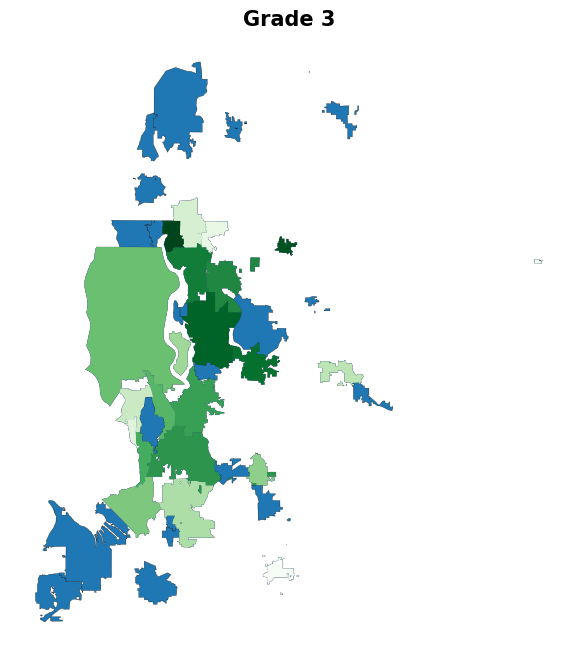

In [181]:
shape_grade = pd.merge(left=shape, right=df_pivot, left_on="NAME", right_on="City", how = 'inner')
shape_grade = gpd.GeoDataFrame(shape_grade)
ax = shape_grade.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_grade.plot(ax = ax , categorical=True,column=3.0, cmap = "Greens")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Grade 3', size = 15, weight = 'bold')

Text(0.5, 1.0, 'Grade 4')

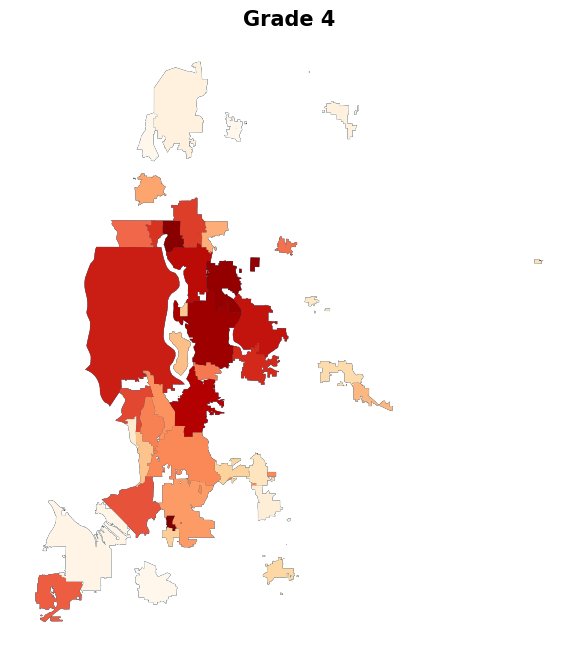

In [182]:
shape_grade = pd.merge(left=shape, right=df_pivot, left_on="NAME", right_on="City", how = 'inner')
shape_grade = gpd.GeoDataFrame(shape_grade)
ax = shape_grade.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_grade.plot(ax = ax , categorical=True,column=1.0, cmap = "OrRd")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Grade 4', size = 15, weight = 'bold')

بررسی امتیاز بازرسی بر اساس شهر ها و زنجیره ای بودن رستوران های شهر
میتوان از نمودار زیر نتیجه گرفت بیشتر رستوران های غیر زنجیره ای در تمامی شهرها بیشترین میانگین امتیاز بازرسی را دریافت کرده اند 

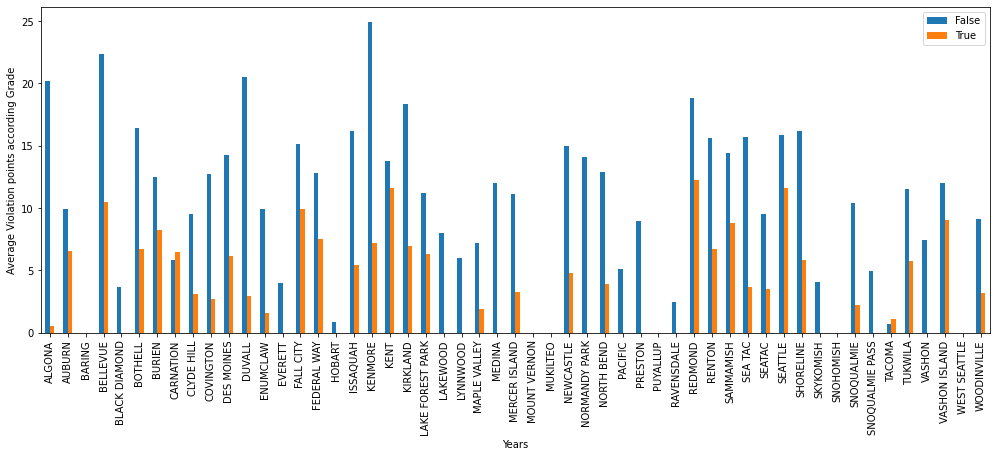

In [150]:
df_pivot = pd.pivot_table(
    df1,
    values="Inspection_Score",
    index="City",
    columns='IS_chain',
    aggfunc='mean'
    
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points according Grade")
ax.legend(bbox_to_anchor=(1.0, 1.0))

از نمودار زیر میتوان نتیجه گرفت بیشتر امتیاز های بازرسی مربوط به رستوران های غیر زنجیره ای است

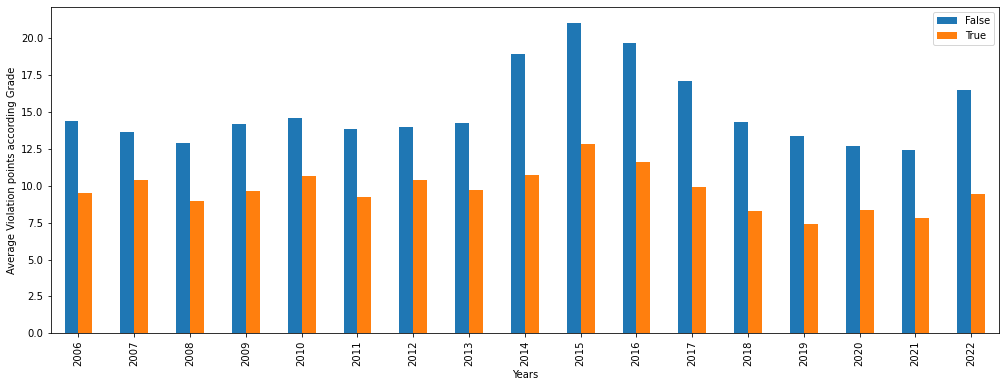

In [158]:
df_pivot = pd.pivot_table(
    df1,
    values="Inspection_Score",
    index="Year",
    columns='IS_chain',
    aggfunc='mean'
    
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points according Grade")
ax.legend(bbox_to_anchor=(1.0, 1.0))

 بیشترین امتیاز های تخلفات 

Text(0.5, 1.0, 'Average Inspection Score in each city')

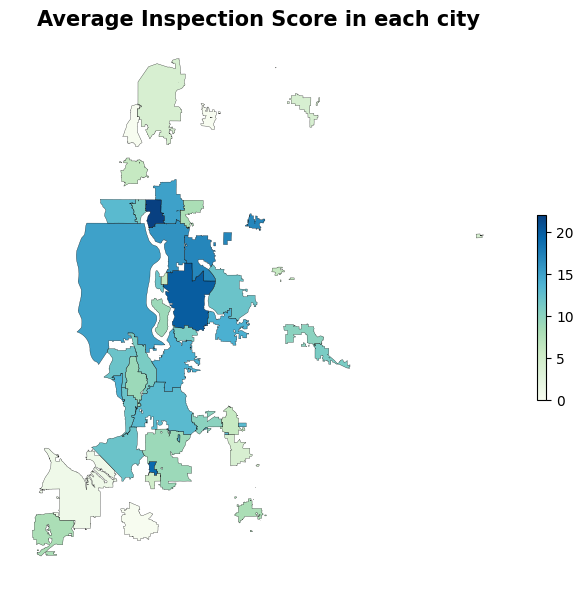

In [184]:
df_Inspection_Score = df[['Name', 'City', 'Inspection_Score']].copy()
df_Inspection_Score = df_Inspection_Score.groupby('City').mean('Inspection_Score').round()
shape_Inspection_Score = pd.merge(left=shape, right=df_Inspection_Score, left_on="NAME", right_on="City", how = 'inner')
shape_Inspection_Score = gpd.GeoDataFrame(shape_Inspection_Score)
ax = shape_Inspection_Score.boundary.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_Inspection_Score.plot(ax = ax , column ='Inspection_Score',legend = True, cmap = "GnBu", legend_kwds={'shrink': 0.3})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Average Inspection Score in each city', size = 15, weight = 'bold')

In [185]:
df_mean1=np.round(data1.groupby(['City','Grade','IS_chain']).agg({'Violation_Points':'mean'})).sort_values(by=['Violation_Points'], ascending=False)
df_mean2=df_mean1.groupby(level=1).head(1)
df_mean2

,,,Violation_Points
City,Grade,IS_chain,
mercer island,2.0,True,30.0
snoqualmie,3.0,False,10.0
bellevue,4.0,False,9.0
medina,1.0,False,5.0


حذف شود

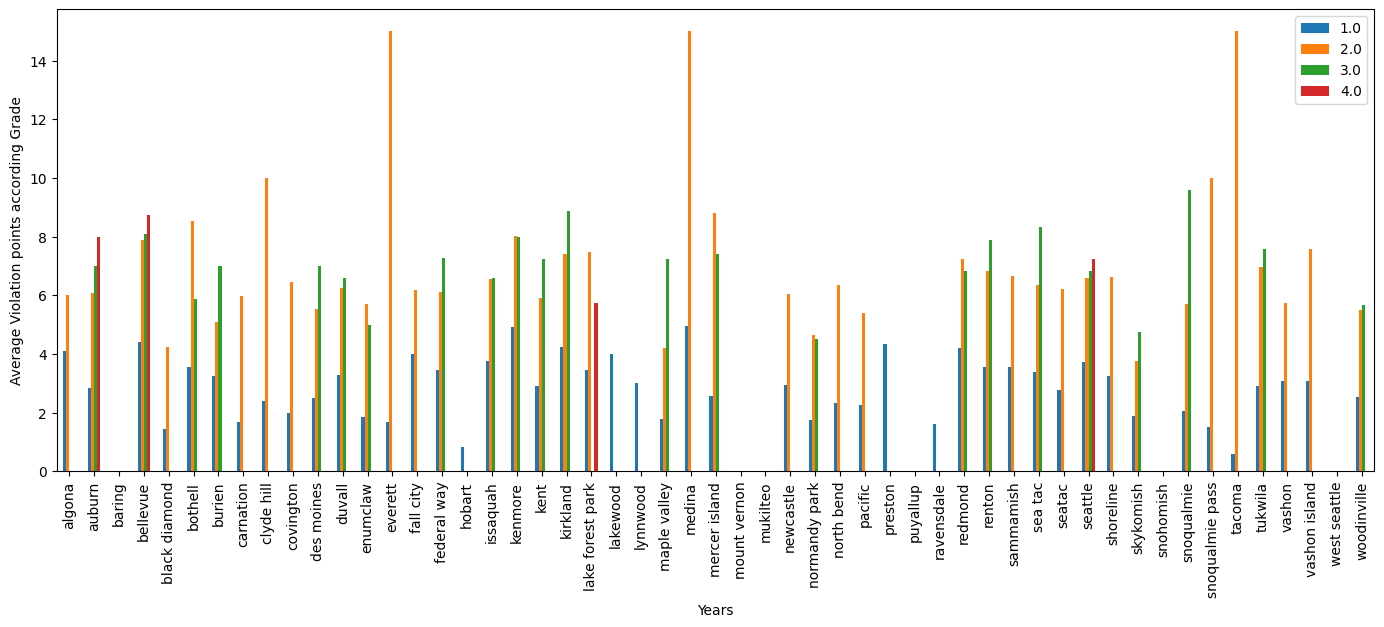

In [186]:
df_pivot = pd.pivot_table(
    df1,
    values="Violation_Points",
    index="City",
    columns='Grade',
    aggfunc='mean'
    
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points according Grade")
ax.legend(bbox_to_anchor=(1.0, 1.0))

حذف

از نمودار زیر میتوان نتیجه گرفت که رستوران های زنجیره ای شهر سیاتل که بیشترین رستوران های زنجیره ای را دارد امتیاز تخلفات قابل توجهی دارند

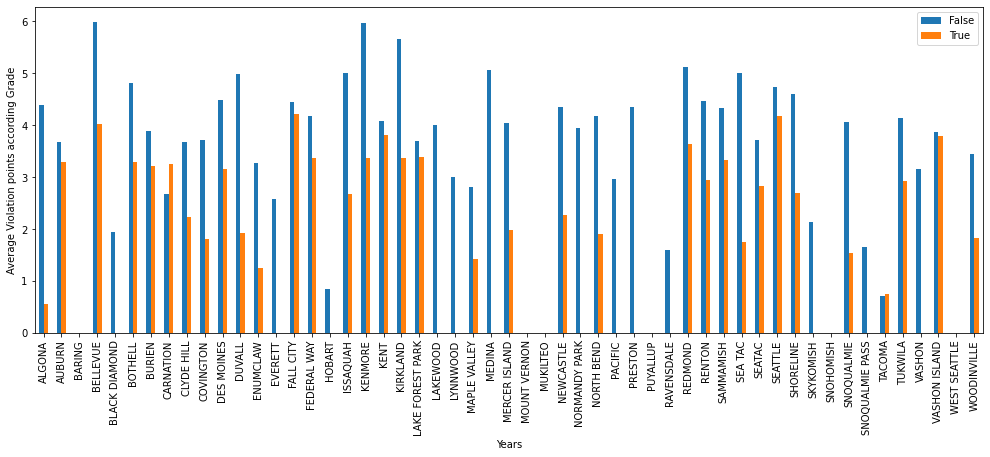

In [153]:
df_pivot = pd.pivot_table(
    df1,
    values="Violation_Points",
    index="City",
    columns='IS_chain',
    aggfunc='mean'
    
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points according Grade")
ax.legend(bbox_to_anchor=(1.0, 1.0))

In [92]:
df_mean1=np.round(df1.groupby(['Grade','Year']).agg({'Inspection_Score':'mean','Violation_Points':'mean'})).sort_values(by=['Violation_Points'], ascending=False)
df_mean=df_mean1.groupby(level=1).head(1)
df_mean

Inspection_Score  Violation_Points
Grade Year                                    
4.0   2014              60.0              10.0
      2020              45.0              10.0
      2007              46.0               9.0
      2022              79.0               8.0
2.0   2015              31.0               8.0
3.0   2021              41.0               8.0
4.0   2016              31.0               8.0
      2018              39.0               8.0
2.0   2017              26.0               7.0
      2019              23.0               7.0
4.0   2011              39.0               7.0
3.0   2012              24.0               6.0
      2009              21.0               6.0
      2008              17.0               6.0
      2013              24.0               6.0
      2010              20.0               6.0
2.0   2006              24.0               6.0

همانطور که واضح است بیشترین امتیاز تخلفات رستوران ها مربوط به سالهای 2007 و2014 و 2020 میباشد که در انها رستوران های درجه 4 بیشترین امتیاز تخلفات را دریافت کرده اند

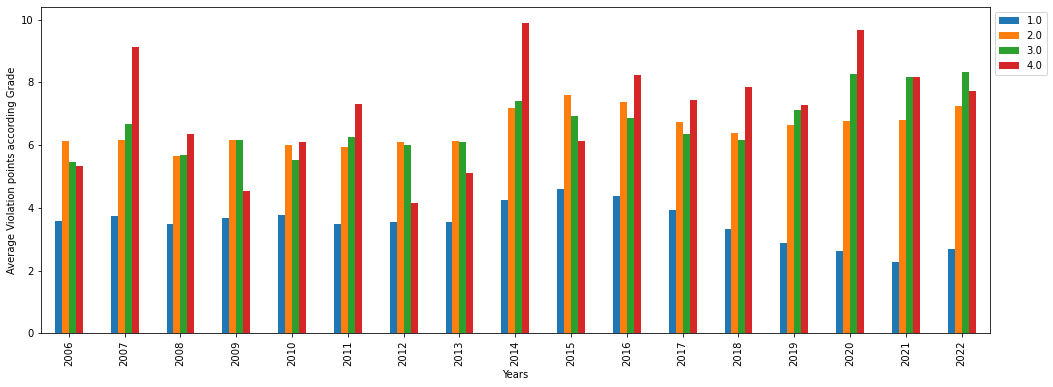

In [94]:
#بررسی میانگین تخلفات رستوران ها بر اساس درجه ان ها
df_pivot = pd.pivot_table(
    df1,
    values="Violation_Points",
    index="Year",
    columns="Grade",
    aggfunc='mean'
    
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points according Grade")
ax.legend(bbox_to_anchor=(1.0, 1.0))

همانطور که از این نمودار و نمودار قبلی مشخص است بیشتر امتیاز تخلفات در سال های مختلف مربوط به رستوران های زنجیره ایی میباشد و این امر بسیار بدیهی است چون تعداد رستوران های زنجیره ای در برابر رستوران های غیر زنجیره ای بسیار کمتر است و این که بیشتر رستوران های زنجیره ای درجه یک و دو هستند و این رستوران ها کمترین میزان امتیازات بازرسی نسبت به رستوران های درجه سه و چهار دارند

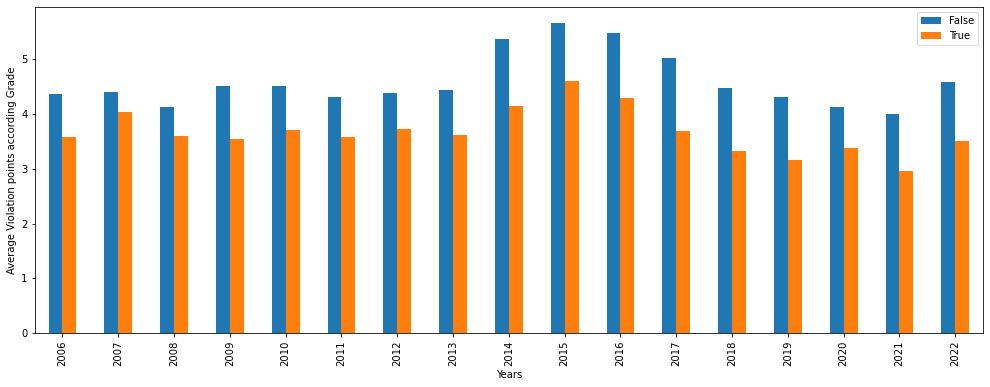

In [154]:
#بررسی میانگین امتیاز تخلفات رستوران زنجیره ای در سال های مختلف
df_pivot = pd.pivot_table(
    df1,
    values="Violation_Points",
    index="Year",
    columns="IS_chain",
    aggfunc='mean'
    
)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points according Grade")
ax.legend(bbox_to_anchor=(1.0, 1.0))

از نمدار زیر میتوان نتیجه گرفت که میانگین امتیاز های تخلفات رستوران ها در بهار ئ تابستان سال 2020 به شدت کاهش پیدا کرده است و علت این موضوع کاهش چشمگیر رستوران ها در این سال میباشد در ادامه به بررسی این کاهش میپردازیم

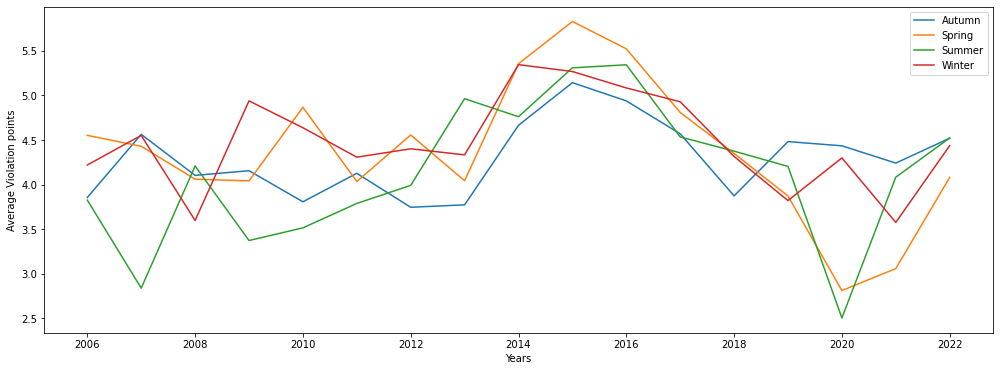

In [106]:
df_pivot = pd.pivot_table(
    df1,
    values="Violation_Points",
    index="Year",
    columns="Season",
    aggfunc='mean'
)
ax = df_pivot.plot(kind="line")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points")
ax.legend(bbox_to_anchor=(1.0, 1.0))

نمودار زیر نشان میدهد که بیشتر رستوران های زنجیره ای و هم غیر زنجیره ای از لحاظ تعداد کاهش چشمگیری در سال 2020 نسبت به پیک خود در سال 2015 داشته اند

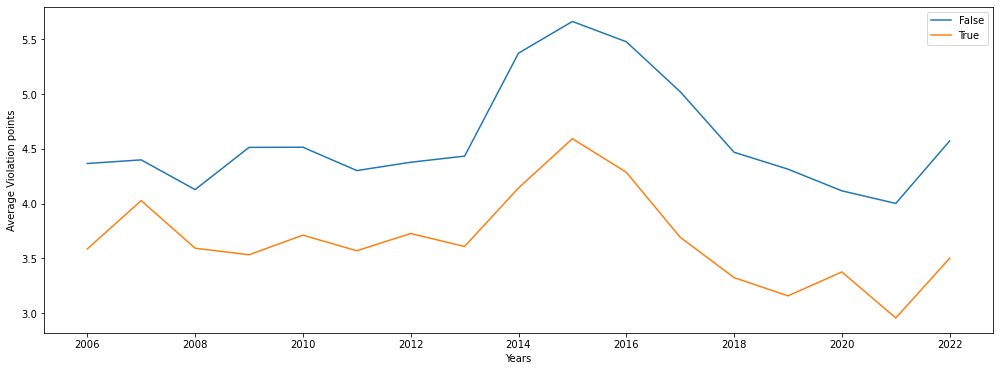

In [159]:
df_pivot = pd.pivot_table(
    df1,
    values="Violation_Points",
    index="Year",
    columns="IS_chain",
    aggfunc='mean'
)
ax = df_pivot.plot(kind="line")
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points")
ax.legend(bbox_to_anchor=(1.0, 1.0))

# در این مرحله به بررسی علل تخلفات رستوران هایی که بیشترین امتیاز را دریافت کرده اند میپردازیم

بررسی توزیع فراوانی هر کارت

In [78]:
total=np.round(df1['Violation_Type'].value_counts(normalize=True)*100)
total.to_frame()

,Violation_Type
Green,44.0
RED,29.0
BLUE,26.0


Text(0.5, 1.0, 'Percentage - Violation Type')

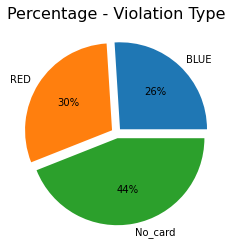

In [79]:
Violation_Type = ['BLUE', 'RED', 'No_card']
Percentage = [26, 30, 44]

fig , ax = plt.subplots()
ax.pie(Percentage,labels = Violation_Type, explode = [0.06]*3, autopct="%.0f%%")
ax.set_title('Percentage - Violation Type', fontsize=16)  

در این جا به این موضوع پرداختیم که کدام نوع تخلفات مشمول دریافت کارت ابی و قرمز و یا سبز گشته اند
همانطور که مشخص است کارت ابی مربوط به بهداشت عمومی و ضد عفونی کردن محیط ظروف و رو میزی ها و ... پرداخته است
و کارت قرمز بیشتر به دمای نگهداری مواد غذایی و سلامت کارکنان و رعایت بهداشت فردی کارکنان پرداخته است

In [110]:
CrosstabResult1=pd.crosstab(index=df1['Violation_Description'],columns=df1['Violation_Type']).sort_values(by = ['BLUE'], ascending = [False])
CrosstabResult1.head(5)

Violation_Type,BLUE,Green,RED
Violation_Description,,,
"3400 - Wiping cloths properly used, stored, proper sanitizer",8607,0,0
"4100 - Warewashing facilities properly installed,...",6972,0,0
"4200 - Food-contact surfaces maintained, clean, sanitized",6253,0,1
"3300 - Potential food contamination prevented during delivery, preparation, storage, display",4946,0,0
4300 - Non-food contact surfaces maintained and clean,4276,0,0


In [109]:
CrosstabResult2=pd.crosstab(index=df1['Violation_Description'],columns=df1['Violation_Type']).sort_values(by = ['RED'], ascending = [False])
CrosstabResult2.head(5)

Violation_Type,BLUE,Green,RED
Violation_Description,,,
2110 - Proper cold holding temperatures (greater than 45 degrees F),18,0,12073
0600 - Adequate handwashing facilities,13,0,10303
2120 - Proper cold holding temperatures ( 42 degrees F to 45 degrees F),0,0,6269
0200 - Food Worker Cards current for all food workers; new food workers trained,0,0,4861
1600 - Proper cooling procedure,2,0,3736


In [21]:
CrosstabResult3=pd.crosstab(index=df1['Violation_Description'],columns=df1['Violation_Type']).sort_values(by = ['Green'], ascending = [False])
CrosstabResult3.head()

Violation_Type,BLUE,Green,RED
Violation_Description,,,
No_violation,0,110655,0
"0100 - PIC certified by accredited program or compliance with code, or correct answers",0,0,325
Food Worker Cards current for all food...,0,0,1356
Accurate thermometer provided and used ...,0,0,473
Adequate equipment for temperature control,401,0,0


در نمودار زیر مشخص گردیده است که رستران هایی با درجه 3 و4 در گروه ریسک پذیری 3 بیشترین امتیاز تخلفات را به خود اختصاص داده اند

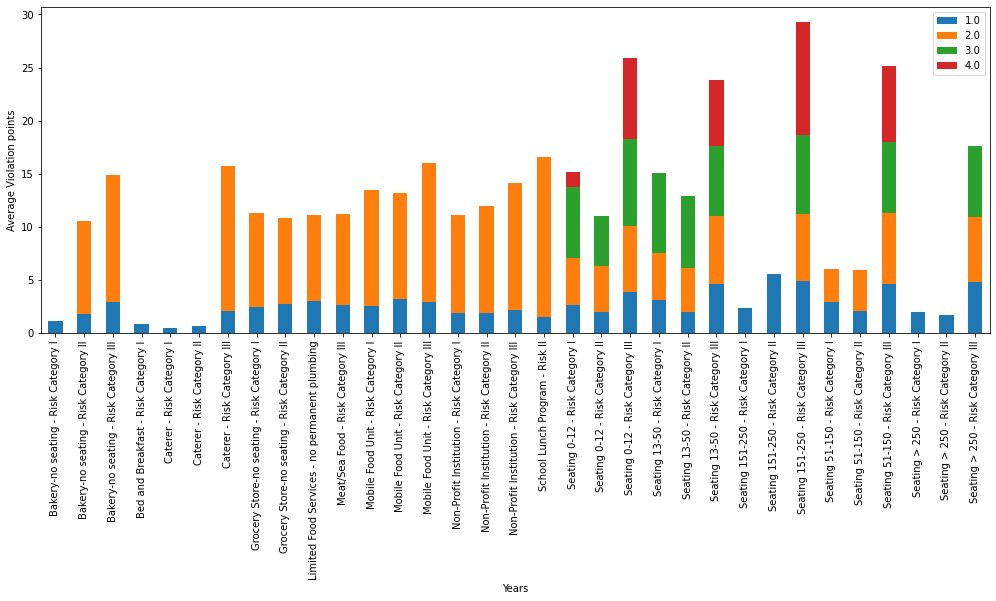

In [81]:
df_pivot = pd.pivot_table(
    df1,
    values=("Violation_Points"),
    index="Description",
    columns='Grade',
    
    aggfunc='mean'    
)
ax = df_pivot.plot(kind="bar",stacked=True,)
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points")
ax.legend(bbox_to_anchor=(1.0, 1.0))

نمودار زیر نشان میدهد کدام گروه از ریسک پذبری دارای بیشترین تعداد کارت تخلفات است

همانطور که از نمودار پایین مشخص است بیشترین تعداد کارتهای دریافتی توسط رستوران هایی با گروه ریسک پذیری 3 میباشد

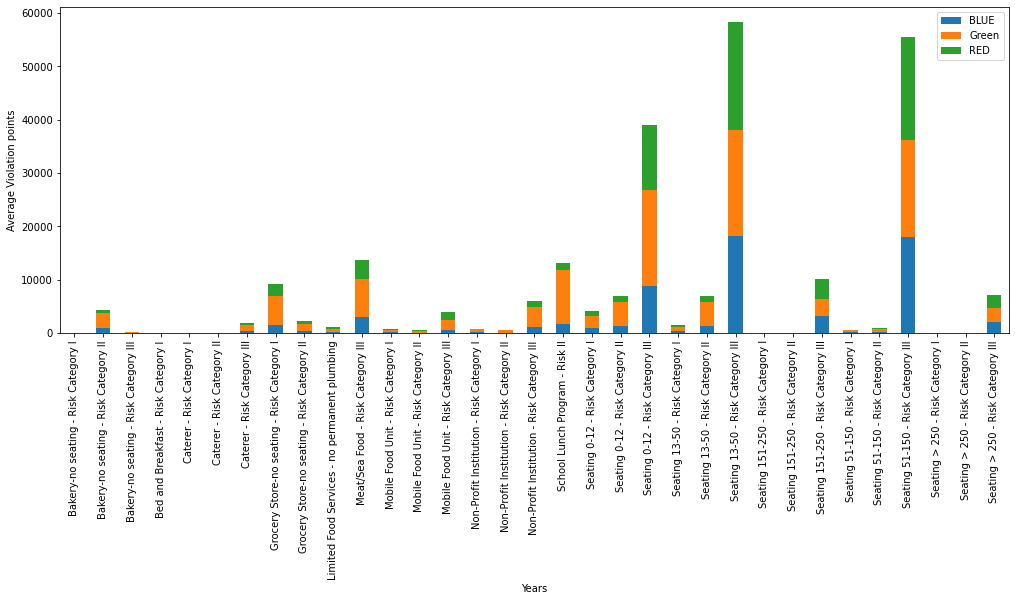

In [161]:
df_pivot = pd.pivot_table(
    df1,
    values=("Violation_Points"),
    index="Description",
    columns='Violation_Type',
    
    aggfunc='count'    
)
ax = df_pivot.plot(kind="bar",stacked=True,)
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points")
ax.legend(bbox_to_anchor=(1.0, 1.0))

نمودار زیر به بررسی رستوران های زنجیره ای و نوع ریسک پذیری بر اساس میانگین امتیاز های تخلفات میردازد

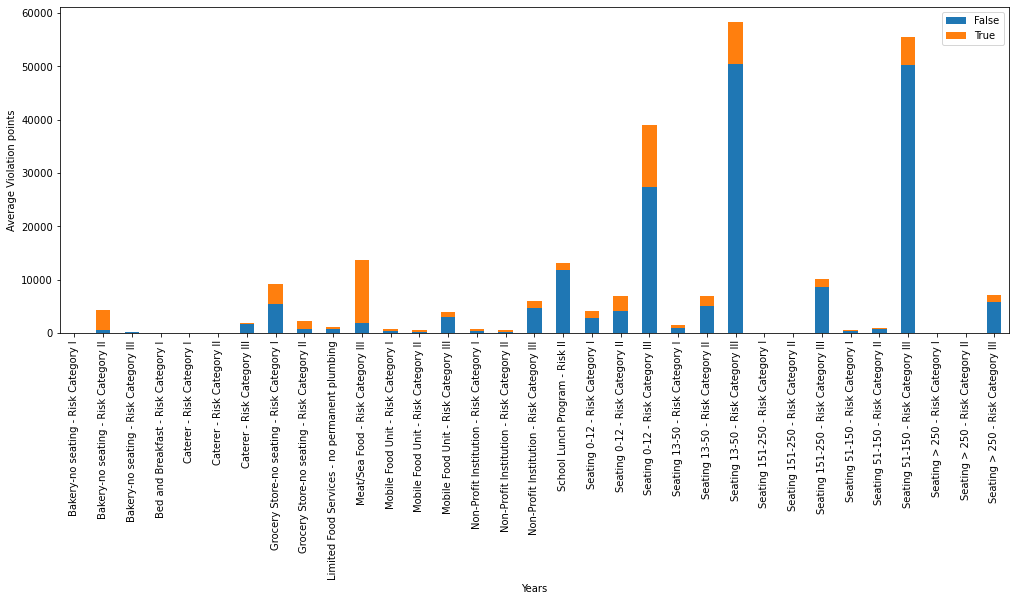

In [163]:
df_pivot = pd.pivot_table(
    df1,
    values=("Violation_Points"),
    index="Description",
    columns='IS_chain',
    
    aggfunc='count'    
)
ax = df_pivot.plot(kind="bar",stacked=True,)
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points")
ax.legend(bbox_to_anchor=(1.0, 1.0))

همانطور که مشخص است شهر سیاتل با بیشترین رستوران های درجه یک و بیشترین رستوران های زنجیره ای دارای بیشترین کارت تخلف قرمز را دریافت کرده است و بیشترین رستوران های بسته شده بر اساس تخلفات را دارد

In [117]:
CrosstabResult4=pd.crosstab(index=df1['City'],columns=df1['Violation_Type']).sort_values(by = ['RED'], ascending = [False])
CrosstabResult4.head(5)

Violation_Type,BLUE,Green,RED
City,,,
SEATTLE,33905,49118,35892
BELLEVUE,4635,6283,6345
KENT,3073,6480,3515
FEDERAL WAY,2996,5579,3405
KIRKLAND,2756,3369,3360


<AxesSubplot: xlabel='City'>

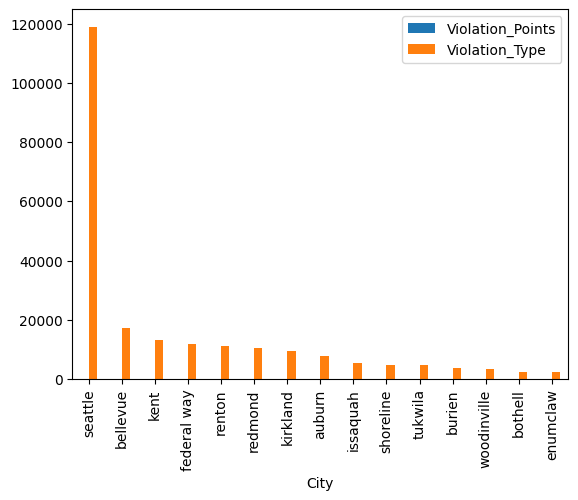

In [187]:
df_mean1=np.round(df1.groupby(['City']).agg({'Violation_Points':'mean','Violation_Type':'count'})).sort_values(by=['Violation_Type'], ascending=False)
df_mean2=df_mean1
df_mean2.head(15).plot(kind='bar')

<AxesSubplot: xlabel='City'>

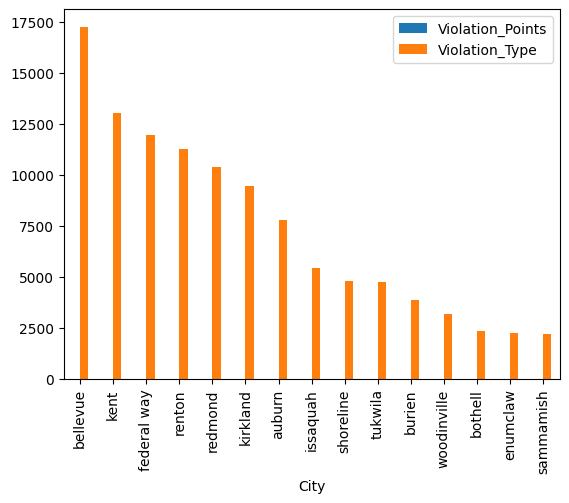

In [189]:
df_mean1=np.round(df1.groupby(['City']).agg({'Violation_Points':'mean','Violation_Type':'count'})).sort_values(by=['Violation_Type'], ascending=False)
df_mean2=df_mean1
df_mean2.drop(['seattle'], axis = 0, inplace =True)
df_mean2.head(15).plot(kind='bar')

شهر سیاتل بیشترین تعداد تخلفات و بیشترین تعداد رستوران های بسته شده را دارد و بیشترین کارت های دریافت شده

In [116]:
#کدام شهر بیشترین تعداد رستوران بسته شده را دارد
CrosstabResult=pd.crosstab(index=df1['City'],columns=df1['Inspection_Closed_Business'])
CrosstabResult


Inspection_Closed_Business,False,True
City,,
ALGONA,157,0
AUBURN,7781,5
BARING,3,0
BELLEVUE,17201,62
BLACK DIAMOND,326,0
BOTHELL,2346,8
BURIEN,3863,1
CARNATION,613,0
CLYDE HILL,110,0


بیشتر تعطیلی ها مربوط به رستوران درجه 2 میباشد , 

Inspection_Closed_Business   False  True 
Grade                                    
1.0                         180605    288
2.0                          60183    319
3.0                           7843     25
4.0                            449     92


<AxesSubplot:xlabel='Grade'>

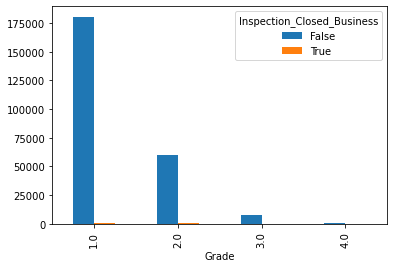

In [188]:
CrosstabResult=pd.crosstab(index=df1['Grade'],columns=df1['Inspection_Closed_Business'])
print(CrosstabResult)
CrosstabResult.plot.bar(figsize=(6,4), rot=90)

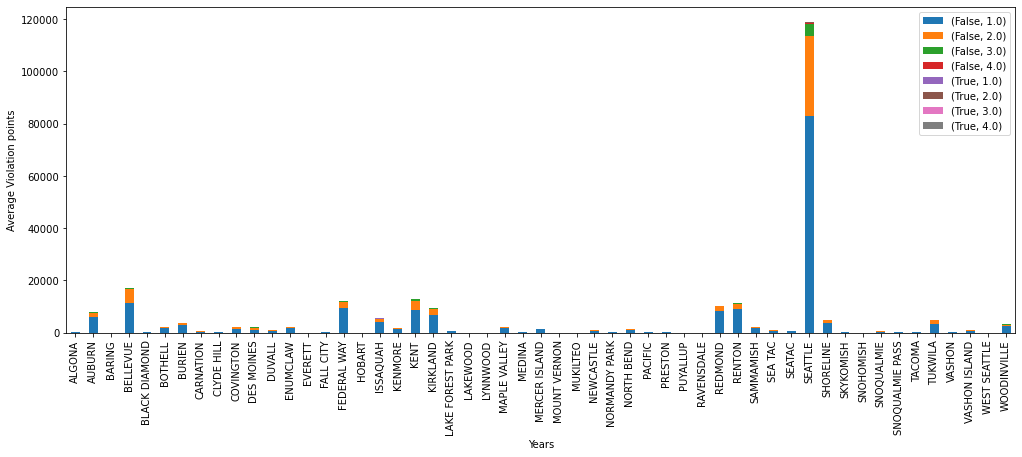

In [183]:
df_pivot = pd.pivot_table(
    df1,
    values=("Violation_Points"),
    index="City",
    columns=('Inspection_Closed_Business','Grade'),
    
    aggfunc='count'    
)
ax = df_pivot.plot(kind="bar",stacked=True,)
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points")
ax.legend(bbox_to_anchor=(1.0, 1.0))

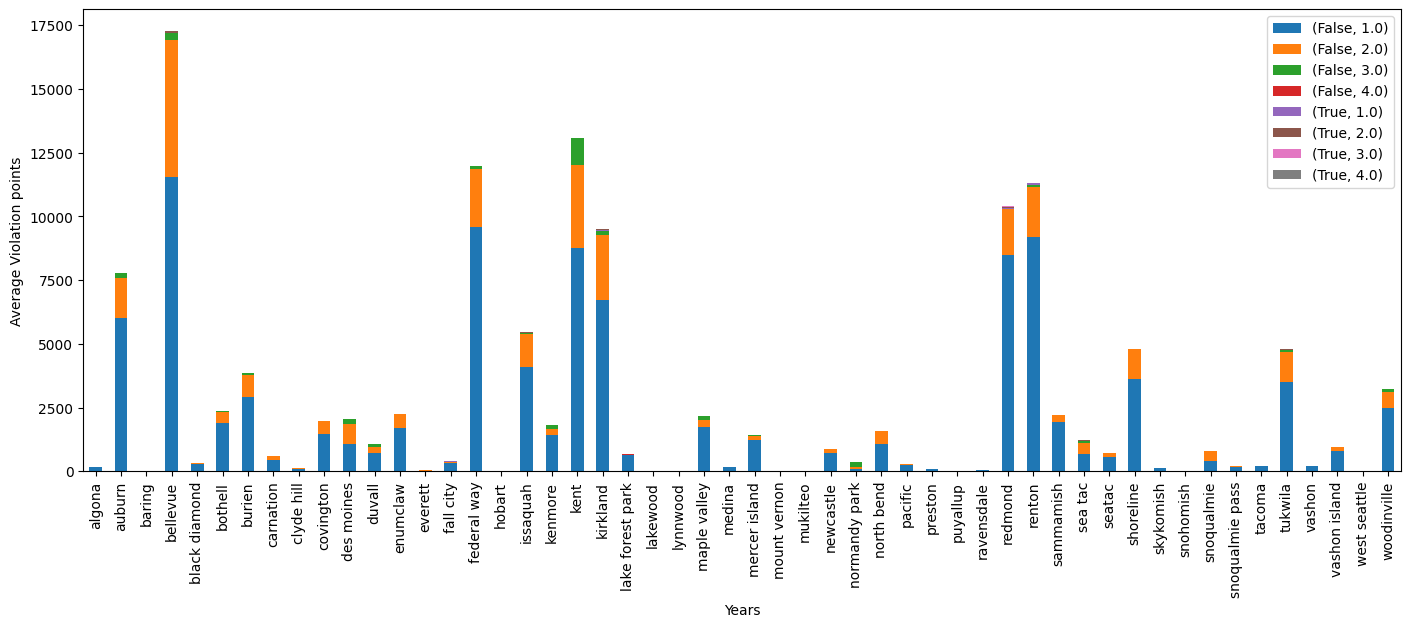

In [190]:
df_pivot = pd.pivot_table(
    df1,
    values=("Violation_Points"),
    index="City",
    columns=('Inspection_Closed_Business','Grade'),
    
    aggfunc='count'    
)
df_pivot.drop(['seattle'], axis = 0, inplace =True)
ax = df_pivot.plot(kind="bar",stacked=True,)
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points")
ax.legend(bbox_to_anchor=(1.0, 1.0))

از این دو نمودار میتوان نتیجه گرفت تعطیلی های سال 2020 به دلیل تخلفات نبوده و بحران جهانی کرونا باعث تعطیلی رستوران ها گشته است 

Inspection_Closed_Business  False  True 
Year                                    
2006                         9777     63
2007                        10300     23
2008                        10534      9
2009                        10664      4
2010                        12352      2
2011                        13329     25
2012                        14869     61
2013                        15446     43
2014                        17396     60
2015                        17145     74
2016                        17530    106
2017                        19096     48
2018                        20414     36
2019                        20548     27
2020                         7331     20
2021                        12794     28
2022                        19355     90


<AxesSubplot:xlabel='Year'>

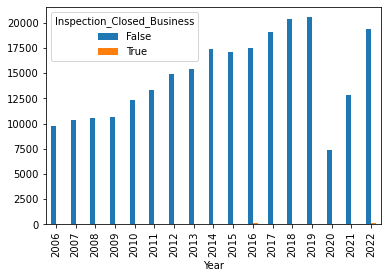

In [73]:
CrosstabResult=pd.crosstab(index=df1['Year'],columns=df1['Inspection_Closed_Business'])
print(CrosstabResult)
CrosstabResult.plot.bar(figsize=(6,4), rot=90)

Inspection_Closed_Business   False  True 
Violation_Type                           
BLUE                         65263    233
Green                       110682     22
RED                          73135    469


<AxesSubplot:xlabel='Violation_Type'>

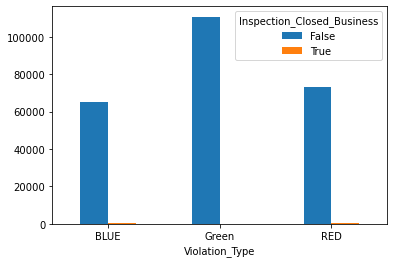

In [189]:
#بر اساس هر کارت چه تعداد رستوران بسته شده یا باز است
CrosstabResult=pd.crosstab(index=df1['Violation_Type'],columns=df1['Inspection_Closed_Business'])
print(CrosstabResult)
CrosstabResult.plot.bar(figsize=(6,4), rot=0)

Violation_Type   BLUE  Green    RED
Grade                              
1.0             42808  94177  43908
2.0             19639  14860  26003
3.0              2815   1586   3467
4.0               234     81    226


<AxesSubplot:xlabel='Grade'>

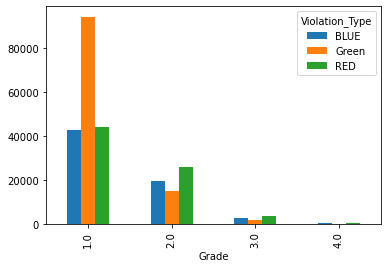

In [190]:
CrosstabResult=pd.crosstab(index=df1['Grade'],columns=df1['Violation_Type'])
print(CrosstabResult)
CrosstabResult.plot.bar(figsize=(6,4), rot=90)

حدود 116 رستوران زنجیره ای بسته شده اند یعنی حدود 16 درصد از رستوران های بسته شده زنجیره ای هستند و نمدار مربوطه در پایین رسم شده است

In [182]:
CrosstabResult=pd.crosstab(index=df1['IS_chain'],columns=df1['Inspection_Closed_Business'])
CrosstabResult

Inspection_Closed_Business,False,True
IS_chain,,
False,188482,608
True,60598,116


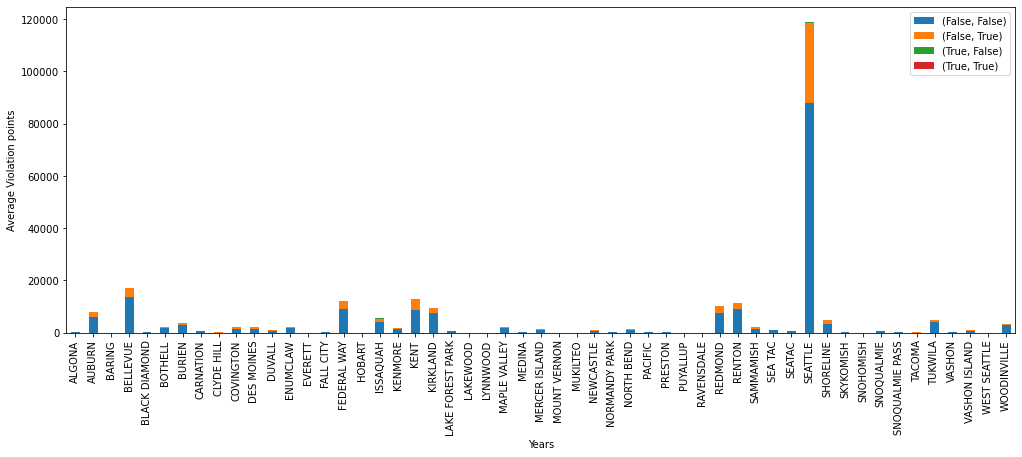

In [172]:
df_pivot = pd.pivot_table(
    df1,
    values=("Violation_Points"),
    index="City",
    columns=('Inspection_Closed_Business',"IS_chain"),
    
    aggfunc='count'    
)
ax = df_pivot.plot(kind="bar",stacked=True,)
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points")
ax.legend(bbox_to_anchor=(1.0, 1.0))

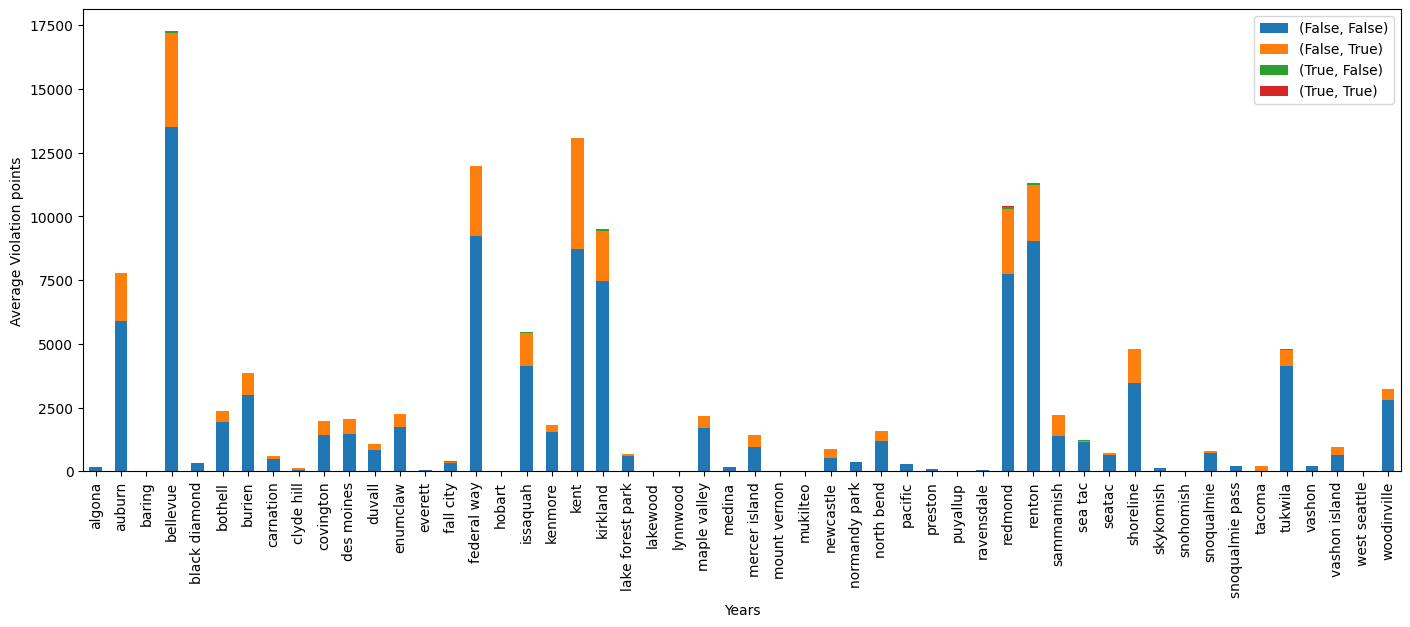

In [191]:
df_pivot = pd.pivot_table(
    df1,
    values=("Violation_Points"),
    index="City",
    columns=('Inspection_Closed_Business',"IS_chain"),
    
    aggfunc='count'    
)
df_pivot.drop(['seattle'], axis = 0, inplace =True)
ax = df_pivot.plot(kind="bar",stacked=True,)
fig = ax.get_figure()
fig.set_size_inches(17, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Average Violation points")
ax.legend(bbox_to_anchor=(1.0, 1.0))

In [192]:
Count_num=np.round(df1['IS_chain'].value_counts(normalize=True)*100)
Count_num

False    76.0
True     24.0
Name: IS_chain, dtype: float64

همانطور که از نمودار زیر مشخص است شهر سیاتل با بیشترین امتیاز تخلف و بیشترین کارت های دریافتی تخلف و دارای بیشترین تعداد رستوران زنجیره ای بیشترین تعداد رستوران های بسته شده را دارد

همانطور که از نمودار پایین نشان میدهد 

Text(0.5, 1.0, 'Closed business in each city')

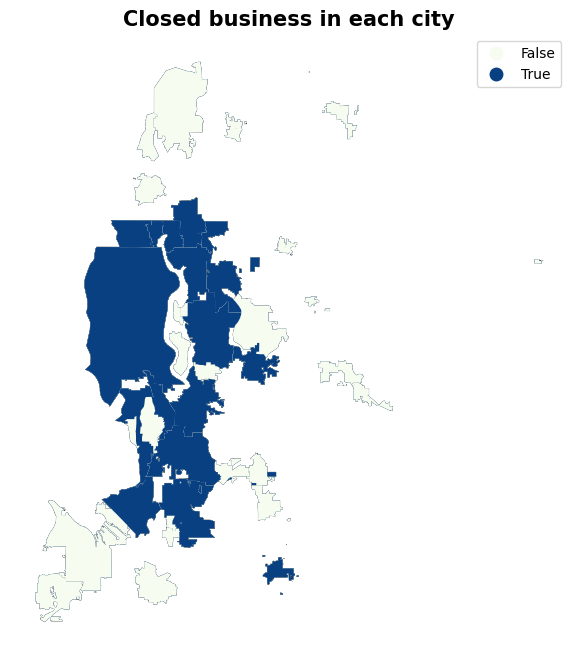

In [193]:
df_Inspection_Closed_Business = df[['Name', 'City', 'Inspection_Closed_Business']].copy()
df_Inspection_Closed_Business = df_Inspection_Closed_Business.groupby(['City',"Inspection_Closed_Business"],as_index=False).size()
shape_Inspection_Closed_Business = pd.merge(left=shape, right=df_Inspection_Closed_Business, left_on="NAME", right_on="City", how = 'inner')
shape_Inspection_Closed_Business = gpd.GeoDataFrame(shape_Inspection_Closed_Business)
ax = shape_Inspection_Closed_Business.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_Inspection_Closed_Business.plot(ax = ax , categorical=True,column ='Inspection_Closed_Business',legend = True, cmap = "GnBu")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Closed business in each city', size = 15, weight = 'bold')

Text(0.5, 1.0, 'Red Violation Type ')

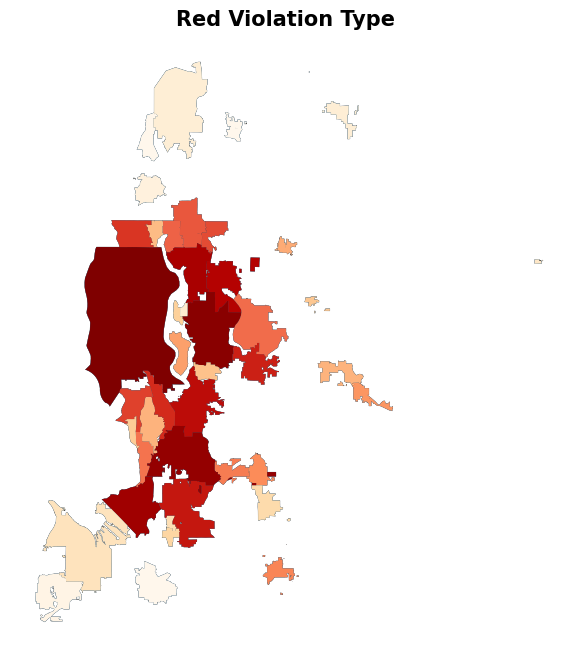

In [153]:
shape_CrosstabResult4 = pd.merge(left=shape, right=CrosstabResult4, left_on="NAME", right_on="City", how = 'inner')
shape_CrosstabResult4 = gpd.GeoDataFrame(shape_CrosstabResult4)
ax = shape_CrosstabResult4.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_CrosstabResult4.plot(ax = ax , categorical=True,column ='RED', cmap = "OrRd")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Red Violation Type ', size = 15, weight = 'bold')

Text(0.5, 1.0, 'Blue Violation Type ')

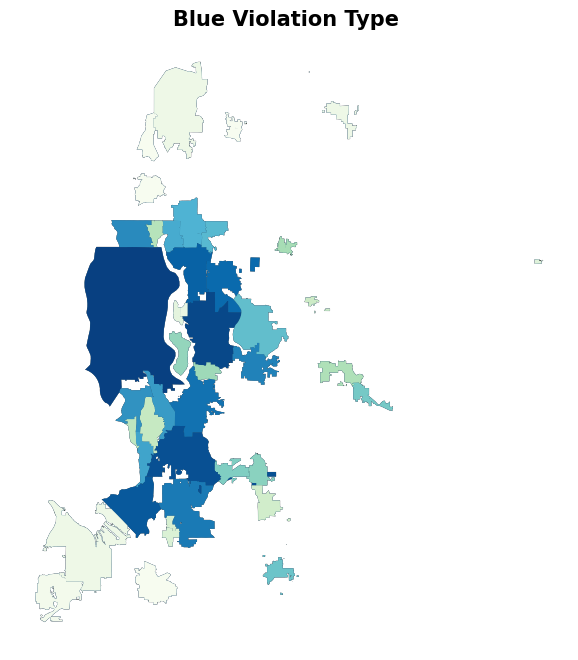

In [150]:
shape_CrosstabResult4 = pd.merge(left=shape, right=CrosstabResult4, left_on="NAME", right_on="City", how = 'inner')
shape_CrosstabResult4 = gpd.GeoDataFrame(shape_CrosstabResult4)
ax = shape_CrosstabResult4.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_CrosstabResult4.plot(ax = ax , categorical=True,column ='BLUE', cmap = "GnBu")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Blue Violation Type ', size = 15, weight = 'bold')

Text(0.5, 1.0, 'GREEN Violation Type ')

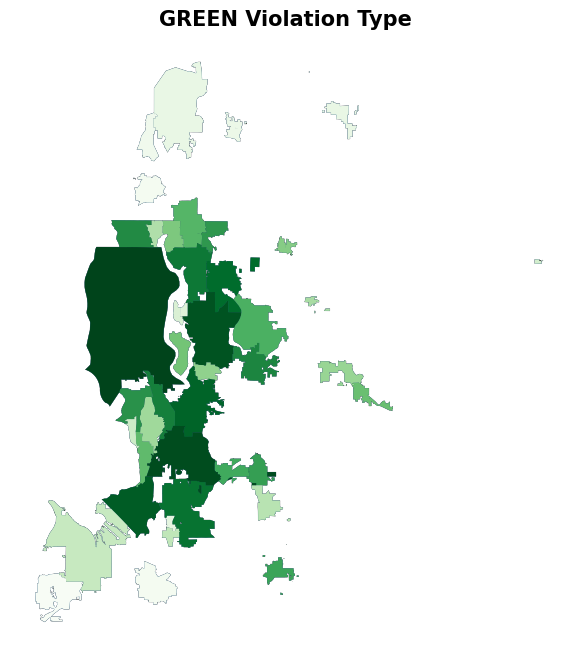

In [155]:
shape_CrosstabResult4 = pd.merge(left=shape, right=CrosstabResult4, left_on="NAME", right_on="City", how = 'inner')
shape_CrosstabResult4 = gpd.GeoDataFrame(shape_CrosstabResult4)
ax = shape_CrosstabResult4.plot(edgecolor = 'black', linewidth = 0.2, figsize = (8,8))
shape_CrosstabResult4.plot(ax = ax , categorical=True,column ='Green', cmap = "Greens")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('GREEN Violation Type ', size = 15, weight = 'bold')